https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
import en_core_web_sm

#gensim library: Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

#vizualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

#clustering
from sklearn.cluster import KMeans

#Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from sklearn.preprocessing import StandardScaler #scale arrays
import multiprocessing #speed up computing
import os #saving & loading models

In [2]:
df = pd.read_csv('procurement_enterprise_sg.csv')
df.shape

(254315, 6)

In [3]:
df.head()

,s/n,Quotation Description,Category,Main Category,Award Month,Award Year
0,52568,Engagement of Video-recording services for the...,Professional Services,Services,January,2013
1,52569,INVITATION TO QUOTE FOR SUPPLY AND INSTALL STA...,General Building & Minor Construction Works,Construction,January,2013
2,52570,Printing and delivery of MOE Long Service Awar...,Printing Services,Administration & Training,January,2013
3,52571,TAMIL LANGUAGE TRANSLATION & TYPE SETTING OF P...,Professional Services,Services,January,2013
4,52572,Production of 5 Videos for Primary Science Syl...,Music & Video,Administration & Training,January,2013


In [4]:
df['Category'].unique().tolist()


[' Professional Services',
 ' General Building & Minor Construction Works',
 ' Printing Services',
 ' Music & Video',
 ' Advertising Services',
 ' Courses',
 ' Photographic & Imaging Services',
 ' Moving Services',
 ' Public Relations & Counselling',
 ' Horticulture Works',
 ' Meeting Venues & Facilities',
 ' Educational Supplies',
 ' IT Services & Software Development',
 ' Gifts & Souvenirs',
 ' Others',
 ' Publications & Periodicals',
 ' Softwares & Licences',
 ' Storage Devices & Drives',
 ' Ticketing, Travel Services, Tours & Excursions',
 ' Data Entry, Supply of Manpower Services',
 ' Sports & Recreational Equipment',
 ' Renovation Supplies & Services',
 ' Copiers',
 ' Bus Hire',
 ' Security Services',
 ' AV Equipment, Photographic Equipment & Accessories',
 ' Cleaning Services',
 ' Tailoring',
 ' Workshop Furniture',
 ' Catering Services',
 ' Event Organising',
 ' Pantry Supplies',
 ' Laboratory Equipment & Supplies',
 ' Office Supplies & Stationery',
 ' Telecommunication Devices

In [5]:
df['Main Category'].value_counts()

Administration & Training                     69852
Services                                      60817
IT & Telecommunication                        25691
Dental, Medical & Laboratory                  21584
Event Organising, Food & Beverages            18879
Construction                                  14830
Facilities Management                         13128
Furniture, Office Equipment & Audio-Visual    11792
Transportation                                 9811
Miscellaneous                                  4979
Workshop Equipment and Services                2948
Unknown Category                                  4
Name: Main Category, dtype: int64

In [6]:
len(df['Category'].unique()),len(df['Main Category'].unique())

(90, 12)

In [7]:
cat_list = df['Main Category'].unique().tolist()
count = 0
for cat in cat_list:
    print(cat)
    try:
        print(df[df['Main Category']== cat].groupby('Category').size().sort_values(ascending=False),'\n')
        sub_cat_count = len(df[df['Main Category']== cat]['Category'].unique())
        count+=sub_cat_count
        print('# of sub cat:  ', sub_cat_count, '\n','total sub cat so far:  ', count)
    except:
        print('no sub cat')
print(count)

Services
Category
 Data Entry, Supply of Manpower Services       31843
 Professional Services                         22669
 Tailoring                                      2549
 Advertising Services                           2146
 Public Relations & Counselling                  809
 Storage Services                                321
 Disposal and Management of Waste Chemicals      226
 Laundry Services                                109
 Grooming Services                               107
 Childcare Services                               26
 Undertaker Services                              12
dtype: int64 

# of sub cat:   11 
 total sub cat so far:   11
Construction
Category
 General Building & Minor Construction Works    4641
 Others                                         2023
 Renovation Supplies & Services                 1779
 Signages                                       1687
 Interior Decoration                            1416
 Civil Engineering                              1

In [8]:
sub_cat_list = df['Category'].unique().tolist()
count = 0
for sub_cat in sub_cat_list:
    print(sub_cat)
    list_size = len(df[df['Category']== sub_cat]['Main Category'].unique())
    if list_size > 1:
        count += list_size
        print(sub_cat,'\n', list_size)

count

 Professional Services
 General Building & Minor Construction Works
 Printing Services
 Music & Video
 Advertising Services
 Courses
 Photographic & Imaging Services
 Moving Services
 Public Relations & Counselling
 Horticulture Works
 Meeting Venues & Facilities
 Educational Supplies
 IT Services & Software Development
 Gifts & Souvenirs
 Others
 Others 
 6
 Publications & Periodicals
 Softwares & Licences
 Storage Devices & Drives
 Ticketing, Travel Services, Tours & Excursions
 Data Entry, Supply of Manpower Services
 Sports & Recreational Equipment
 Renovation Supplies & Services
 Copiers
 Bus Hire
 Security Services
 AV Equipment, Photographic Equipment & Accessories
 Cleaning Services
 Tailoring
 Workshop Furniture
 Catering Services
 Event Organising
 Pantry Supplies
 Laboratory Equipment & Supplies
 Office Supplies & Stationery
 Telecommunication Devices
 Furniture
 Art Supplies
 Disposal Management
 Desktop Computers
 Workshop Machinery, DIY Machinery & Supplies
 Repairs & Red

6

In [97]:
#df with text (quotation combined with category)
pd.set_option('display.max_colwidth', -1)
df_text = pd.DataFrame({'text': df['Quotation Description']+ ' '+ df['Category'].str.replace('&','').str.strip().str.replace(' ','_')})
df_text = df_text.dropna().drop_duplicates()

df_text.head()

,text
0,Engagement of Video-recording services for the OECD Seminar 2013 (15 - 17 Jan 2013) Professional_Services
1,"INVITATION TO QUOTE FOR SUPPLY AND INSTALL STAINLESS STEEL FILE HOLDERS INSIDE TOILET CUBICLES AT NO. 2 MALAN ROAD, SINGAPORE 109433 General_Building__Minor_Construction_Works"
2,Printing and delivery of MOE Long Service Awards (LSA) Certificates (with envelopes) Printing_Services
3,TAMIL LANGUAGE TRANSLATION & TYPE SETTING OF PROFICIENCY DESCRIPTORS MAIN BOOKLET Professional_Services
4,Production of 5 Videos for Primary Science Syllabus Music__Video


In [98]:
df.shape, df_text.shape

((254315, 6), (238817, 1))

In [99]:
df_text.isnull().sum()

text    0
dtype: int64

In [100]:
df_text[df_text.isnull().any(axis=1)].head()

,text


In [101]:
# disabling Named Entity Recognition for speed
# nlp = spacy.load('en', disable=['ner', 'parser']) 

In [102]:
# import en_core_web_sm
nlp = en_core_web_sm.load(disable=['ner', 'parser'])

In [103]:
nlp

In [216]:
doc_test = nlp("others")
type(doc_test)

spacy.tokens.doc.Doc

In [217]:
doc_test[0].lemma_

'other'

In [218]:
doc_test[0].is_stop

True

In [107]:
# doc needs to be a spacy Doc object
def cleaning(doc):
    # Lemmatizes and removes stopwords (allow others)
    txt = [token.lemma_ for token in doc if not token.is_stop] #...and token is not 'others'
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [108]:
# re.sub example
doc_test2 = 'Az1$,. &%3ws_'
re.sub("[^A-Za-z_']+", ' ', str(doc_test2))

'Az ws_'

In [109]:
# Removes non-alphabetic characters:
brief_cleaning = (re.sub("[^A-Za-z_']+", ' ', str(row)).lower() for row in df_text['text'])

In [110]:
type(brief_cleaning)

generator

In [111]:
bf_list = list(brief_cleaning)

In [112]:
len(bf_list), bf_list[len(bf_list)-1]

(238817, 'renewal of backup software licences maintenance softwares__licences')

In [113]:
df_text.tail()

,text
254309,"Tender For The Distribution Of 500 Copies Of ""Greening The Vertical Garden City"" And 500 Copies Of ""Vertical Garden City: Singapore"" Publications Publications__Periodicals"
254310,Conceptualisation And Design For URA 2019 Exhibition Professional_Services
254311,"Term Contract For Supply, Installation And Maintenance Of Solar Lighted Signboards At Vehicle Parks For A Period Of Three Years With An Option To Extend For Two Years. Building,_ME_Maintenance"
254312,"Term Contract For Electrical Minor Works For Maintenance Of Lighting Systems In Vehicle Parks For A Period Of Three (3) Years With An Option To Extend For Two (2) Years Building,_ME_Maintenance"
254314,Renewal Of Backup Software Licences Maintenance Softwares__Licences


In [114]:
# Clean text
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(bf_list, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 4.6 mins


In [115]:
len(txt)

238817

In [116]:
txt[-5]

'tender distribution copy green vertical garden city copy vertical garden city singapore publication publications__periodical'

In [117]:
#clean text
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
type(df_clean), df_clean.shape

(pandas.core.frame.DataFrame, (224133, 1))

In [118]:
df_clean.head()

,clean
0,engagement video recording service oecd seminar jan professional_service
1,invitation quote supply install stainless steel file holder inside toilet cubicle malan road singapore general_building__minor_construction_work
2,printing delivery moe long service award lsa certificate envelope printing_service
3,tamil language translation type setting proficiency descriptor main booklet professional_service
4,production video primary science syllabus music__video


Bigrams:

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [119]:
from gensim.models.phrases import Phrases, Phraser

In [120]:
# As Phrases() takes a list of list of words as input:
sent = [row.split() for row in df_clean['clean']]

In [121]:
total = 0
for sentence in sent:
    total += len(sentence)
total, len(sent)

(2883111, 224133)

In [122]:
count = 0
for sentence in sent:
    for word in sentence:
        if len(word) < 3:
#             print(word)
            count += 1
count

190243

In [123]:
#remove word len size 2 or less
for i in range(10):
    for sentence in sent:
        for word in sentence:
            if len(str(word).strip()) < 3:
                sentence.remove(word)

In [124]:
count = 0
for sentence in sent:
    for word in sentence:
        if len(word) < 3:
#             print(word)
            count += 1
count

0

In [125]:
# Creates the relevant phrases from the list of sentences:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 18:01:52: collecting all words and their counts
INFO - 18:01:52: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 18:01:52: PROGRESS: at sentence #10000, processed 116353 words and 51485 word types
INFO - 18:01:52: PROGRESS: at sentence #20000, processed 230949 words and 100057 word types
INFO - 18:01:52: PROGRESS: at sentence #30000, processed 347684 words and 140390 word types
INFO - 18:01:52: PROGRESS: at sentence #40000, processed 466894 words and 176842 word types
INFO - 18:01:53: PROGRESS: at sentence #50000, processed 584920 words and 202397 word types
INFO - 18:01:53: PROGRESS: at sentence #60000, processed 702825 words and 232316 word types
INFO - 18:01:53: PROGRESS: at sentence #70000, processed 822746 words and 258930 word types
INFO - 18:01:53: PROGRESS: at sentence #80000, processed 942634 words and 287246 word types
INFO - 18:01:53: PROGRESS: at sentence #90000, processed 1066887 words and 306160 word types
INFO - 18:01:54: PROGRESS: at sentence 

In [126]:
# The goal of Phraser() is to cut down memory consumption of Phrases(), 
# by discarding model state not strictly needed for the bigram detection task:
bigram = Phraser(phrases)

INFO - 18:02:03: source_vocab length 566506
INFO - 18:02:10: Phraser built with 2685 phrasegrams


In [127]:
# Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [128]:
# Most Frequent Words:
# Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

39030

In [129]:
word_freq

defaultdict(int,
            {'engagement': 2371,
             'video_recording': 77,
             'service': 32565,
             'oecd': 6,
             'seminar': 585,
             'jan': 1840,
             'professional_service': 20490,
             'invitation_quote': 23386,
             'supply': 62813,
             'install': 2923,
             'stainless_steel': 314,
             'file': 1013,
             'holder': 321,
             'inside': 54,
             'toilet': 362,
             'cubicle': 34,
             'malan': 29,
             'road': 2528,
             'singapore': 12850,
             'general_building__minor_construction_work': 4251,
             'printing': 2739,
             'delivery': 17734,
             'moe': 1004,
             'long': 313,
             'award': 1351,
             'lsa': 21,
             'certificate': 550,
             'envelope': 354,
             'printing_service': 7634,
             'tamil_language': 230,
             'translation': 23

In [260]:
for word in word_freq:
    if '_' in word:
        print(word)

video_recording
professional_service
invitation_quote
stainless_steel
general_building__minor_construction_work
printing_service
tamil_language
music__video
advertisement_strait
advertising_service
character_citizenship
seminar_package
photographic__imaging_service
consultancy_service
cyber_wellness
professional_mover
buona_vista
moving_service
chinese_language
ministry_education
public_relations__counsell
video_clip
malay_language
bus_stop
potted_plant
award_ceremony
january_december
horticulture_work
talent_development
meeting_venues__facilitie
educational_supplie
instructional_material
education_career
mother_tongue
portal_it_services__software_development
magnetic_whiteboard
gifts__souvenir
game_nsg
book_publications__periodical
publications__periodical
social_emotional
datum_entry
story_book
fully_operational
softwares__licence
videography_photography
storage_devices__drif
software_license
online_portal
it_services__software_development
immersion_programme
ticket_travel_service
to

taiwan_ticket
projector_av_equipment
photographic_equipment__accessorie
network_infrastructure
chair_furniture
ice_cream
license_renewal
fuel_cell
milling_machine
business_excellence
swimming_pool
propose_cyclical
cyclical_maintenance
people_association
publicity_campaign
temporary_staff
outward_bind
interior_fit
installation_aircondition
chingay_parade
south_east
sit_dinner
youth_council
contingent_chingay
greet_card
business_continuity
walkie_talkie
youth_movement
community_leadership
south_west
south_buona
vista_road
short_message
singapore_obs
grassroots_leader
buffet_lunch
replacement_faulty
main_entrance
water_venture
organize_conduct
passion_card
emergency_response
team_cert
north_east
book_stationery
west_cdc
marketing_collateral
perception_survey
survey_survey_servic
kang_waterworks
kranji_water
reclamation_plant
bedok_newater
bedok_waterworks
changi_water
jurong_island
treatment_plant
chestnut_avenue
waterworks_building
ulu_pandan
water_reclamation
kranji_newater
rectificatio

tan_yi_wen
chua_wei_sun
ee_low
egd_total
fct_winch
efm_repair
efm_maintenance
efm_replacement
cge_engagement
efm_water
shirley_hp_tan
bahtera_outdoor
lim_xiang_wei_kelvin
lau_yean
response_team
tampine_hub
cls_tel
sec_school
lee_yi_wei
joseph_convent
ee_optimized
ee_pem
rte_intercom
rte_slid
ae_technical
format_printer
efm_remount_maintenance
surveying_consultancy
cda_op
chip_classab_mim_cap
chip_system
vc_mim_cap
chip_l
scared_trick
teresa_tee
agarwal_shuchi
michelle_tan
tan_beng_tian
lim_gek_hong_sharon
beng_tian
institution_junior
criterion_price
fct_refrigerant
dilshad_ahmad
mohamed_lokman_mohd_yusof
kang_han_ying_ivorie
richard_kooi
itq_efm
me_diaphragm
me_modular
ee_furniture
me_air
peg_horizontal
hr_remount
aet_fire
me_design
fct_interactive
me_supply
fme_building
lee_wen_yen
ee_open
mre_fluid
fct_repair
peg_mastercam
ee_ite
performance_liquid
science_provision
earthworks_construction
furniture_list
lexile_based
itq_web
fme_furniture
fct_tree
ee_column
fct_sub
fct_digital
me_sim

In [133]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['school',
 'supply',
 'course',
 'provision',
 'service',
 'year',
 'instructor',
 'data_entry_supply_of_manpower_service',
 'programme',
 'primary']

In [134]:
type(word_freq)

collections.defaultdict

In [135]:
import collections
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(word_freq.items(), reverse=True, key=lambda kv: kv[1])
sorted_dict = collections.OrderedDict(sorted_x)
sorted_dict

OrderedDict([('school', 63448),
             ('supply', 62813),
             ('course', 40921),
             ('provision', 39366),
             ('service', 32565),
             ('year', 27729),
             ('instructor', 27584),
             ('data_entry_supply_of_manpower_service', 26589),
             ('programme', 25268),
             ('primary', 23640),
             ('invitation_quote', 23386),
             ('professional_service', 20490),
             ('delivery', 17734),
             ('system', 16325),
             ('laboratory_equipment__supplie', 15548),
             ('student', 14842),
             ('secondary', 14615),
             ('singapore', 12850),
             ('period', 11943),
             ('quotation', 11146),
             ('training', 11096),
             ('itq', 10259),
             ('design', 9572),
             ('maintenance', 9099),
             ('option_extend', 8880),
             ('sec', 7817),
             ('printing_service', 7634),
             ('it_servi

Training the model

Gensim Word2Vec Implementation:

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [136]:
import multiprocessing
from gensim.models import Word2Vec

Why I seperate the training of the model in 3 steps:

I prefer to separate the training in 3 distinctive steps for clarity and monitoring.

Word2Vec():
In this first step, I set up the parameters of the model one-by-one. 
I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

.build_vocab():
Here it builds the vocabulary from a sequence of sentences and thus initialized the model. 
With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

.train():
Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [137]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count() 
cores

4

**The Word2Vec parameters:**

min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)

window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

size = int - Dimensionality of the feature vectors. - (50, 300)

sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)

alpha = float - The initial learning rate - (0.01, 0.05)

min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)

workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [151]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
#                      sg = 1, # useful for large dataset
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

**Building the Vocabulary Table:**

Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [152]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 22:09:29: collecting all words and their counts
INFO - 22:09:29: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:09:30: PROGRESS: at sentence #10000, processed 98135 words, keeping 8816 word types
INFO - 22:09:30: PROGRESS: at sentence #20000, processed 197224 words, keeping 13768 word types
INFO - 22:09:30: PROGRESS: at sentence #30000, processed 297412 words, keeping 16897 word types
INFO - 22:09:31: PROGRESS: at sentence #40000, processed 399526 words, keeping 19413 word types
INFO - 22:09:31: PROGRESS: at sentence #50000, processed 499260 words, keeping 20875 word types
INFO - 22:09:32: PROGRESS: at sentence #60000, processed 600683 words, keeping 22723 word types
INFO - 22:09:33: PROGRESS: at sentence #70000, processed 702908 words, keeping 24237 word types
INFO - 22:09:33: PROGRESS: at sentence #80000, processed 805493 words, keeping 25887 word types
INFO - 22:09:33: PROGRESS: at sentence #90000, processed 908043 words, keeping 26865 word types


Time to build vocab: 0.19 mins


**Training of the model:**<br>
*Parameters of the training:*

total_examples = int - Count of sentences;<br>
epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [153]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 22:09:58: training model with 3 workers on 8071 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 22:09:59: EPOCH 1 - PROGRESS: at 9.04% examples, 91901 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:00: EPOCH 1 - PROGRESS: at 18.29% examples, 97765 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:01: EPOCH 1 - PROGRESS: at 28.05% examples, 100052 words/s, in_qsize 1, out_qsize 0
INFO - 22:10:02: EPOCH 1 - PROGRESS: at 37.22% examples, 100295 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:03: EPOCH 1 - PROGRESS: at 46.35% examples, 99500 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:04: EPOCH 1 - PROGRESS: at 56.09% examples, 100082 words/s, in_qsize 1, out_qsize 0
INFO - 22:10:05: EPOCH 1 - PROGRESS: at 65.30% examples, 99520 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:06: EPOCH 1 - PROGRESS: at 73.25% examples, 96750 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:07: EPOCH 1 - PROGRESS: at 82.99% examples, 96928 words/s, in_qsize 1, out_qsize 0


INFO - 22:11:12: EPOCH 5 - PROGRESS: at 99.72% examples, 57826 words/s, in_qsize 1, out_qsize 1
INFO - 22:11:12: worker thread finished; awaiting finish of 1 more threads
INFO - 22:11:12: worker thread finished; awaiting finish of 0 more threads
INFO - 22:11:12: EPOCH - 5 : training on 2285365 raw words (1093245 effective words) took 18.9s, 57929 effective words/s
INFO - 22:11:13: EPOCH 6 - PROGRESS: at 8.60% examples, 85896 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:14: EPOCH 6 - PROGRESS: at 17.44% examples, 90910 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:15: EPOCH 6 - PROGRESS: at 25.86% examples, 90664 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:16: EPOCH 6 - PROGRESS: at 31.94% examples, 85085 words/s, in_qsize 1, out_qsize 0
INFO - 22:11:17: EPOCH 6 - PROGRESS: at 36.77% examples, 77644 words/s, in_qsize 1, out_qsize 0
INFO - 22:11:18: EPOCH 6 - PROGRESS: at 41.51% examples, 72636 words/s, in_qsize 1, out_qsize 0
INFO - 22:11:19: EPOCH 6 - PROGRESS: at 46.35% examples, 6

INFO - 22:12:29: EPOCH 9 - PROGRESS: at 90.33% examples, 55049 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:30: EPOCH 9 - PROGRESS: at 94.81% examples, 55060 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:31: EPOCH 9 - PROGRESS: at 99.33% examples, 55003 words/s, in_qsize 1, out_qsize 0
INFO - 22:12:31: worker thread finished; awaiting finish of 2 more threads
INFO - 22:12:31: worker thread finished; awaiting finish of 1 more threads
INFO - 22:12:31: worker thread finished; awaiting finish of 0 more threads
INFO - 22:12:31: EPOCH - 9 : training on 2285365 raw words (1093883 effective words) took 19.9s, 55099 effective words/s
INFO - 22:12:32: EPOCH 10 - PROGRESS: at 3.24% examples, 31187 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:33: EPOCH 10 - PROGRESS: at 8.60% examples, 43464 words/s, in_qsize 1, out_qsize 0
INFO - 22:12:34: EPOCH 10 - PROGRESS: at 13.93% examples, 47395 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:35: EPOCH 10 - PROGRESS: at 18.76% examples, 49167 words/s, in_q

INFO - 22:13:45: EPOCH 13 - PROGRESS: at 39.39% examples, 70195 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:46: EPOCH 13 - PROGRESS: at 43.69% examples, 65985 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:47: EPOCH 13 - PROGRESS: at 48.08% examples, 63228 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:48: EPOCH 13 - PROGRESS: at 52.50% examples, 61145 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:49: EPOCH 13 - PROGRESS: at 56.99% examples, 59140 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:50: EPOCH 13 - PROGRESS: at 61.43% examples, 57548 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:51: EPOCH 13 - PROGRESS: at 64.86% examples, 56016 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:52: EPOCH 13 - PROGRESS: at 69.25% examples, 55140 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:53: EPOCH 13 - PROGRESS: at 73.73% examples, 54227 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:55: EPOCH 13 - PROGRESS: at 78.05% examples, 53535 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:56: EPOCH 13 - PR

INFO - 22:15:03: EPOCH 17 - PROGRESS: at 17.44% examples, 92218 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:04: EPOCH 17 - PROGRESS: at 25.86% examples, 91252 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:05: EPOCH 17 - PROGRESS: at 30.25% examples, 79210 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:06: EPOCH 17 - PROGRESS: at 34.51% examples, 72059 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:07: EPOCH 17 - PROGRESS: at 38.96% examples, 67353 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:08: EPOCH 17 - PROGRESS: at 43.26% examples, 63540 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:09: EPOCH 17 - PROGRESS: at 47.66% examples, 61223 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:10: EPOCH 17 - PROGRESS: at 52.08% examples, 59599 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:11: EPOCH 17 - PROGRESS: at 56.53% examples, 58046 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:13: EPOCH 17 - PROGRESS: at 60.98% examples, 56616 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:14: EPOCH 17 - PR

INFO - 22:16:22: worker thread finished; awaiting finish of 2 more threads
INFO - 22:16:22: worker thread finished; awaiting finish of 1 more threads
INFO - 22:16:22: worker thread finished; awaiting finish of 0 more threads
INFO - 22:16:22: EPOCH - 20 : training on 2285365 raw words (1093759 effective words) took 19.7s, 55474 effective words/s
INFO - 22:16:23: EPOCH 21 - PROGRESS: at 8.60% examples, 89073 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:24: EPOCH 21 - PROGRESS: at 15.68% examples, 82336 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:25: EPOCH 21 - PROGRESS: at 20.10% examples, 69950 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:26: EPOCH 21 - PROGRESS: at 24.58% examples, 63518 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:27: EPOCH 21 - PROGRESS: at 28.91% examples, 60198 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:28: EPOCH 21 - PROGRESS: at 32.81% examples, 57667 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:29: EPOCH 21 - PROGRESS: at 37.22% examples, 55841 words/s,

INFO - 22:17:39: EPOCH 24 - PROGRESS: at 10.35% examples, 50668 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:40: EPOCH 24 - PROGRESS: at 14.79% examples, 49487 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:41: EPOCH 24 - PROGRESS: at 20.10% examples, 50992 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:42: EPOCH 24 - PROGRESS: at 25.00% examples, 50821 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:43: EPOCH 24 - PROGRESS: at 29.80% examples, 51144 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:45: EPOCH 24 - PROGRESS: at 34.51% examples, 51293 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:46: EPOCH 24 - PROGRESS: at 39.39% examples, 50937 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:47: EPOCH 24 - PROGRESS: at 44.58% examples, 51104 words/s, in_qsize 1, out_qsize 0
INFO - 22:17:48: EPOCH 24 - PROGRESS: at 49.87% examples, 51704 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:49: EPOCH 24 - PROGRESS: at 55.22% examples, 51743 words/s, in_qsize 0, out_qsize 0
INFO - 22:17:50: EPOCH 24 - PR

INFO - 22:19:00: EPOCH 27 - PROGRESS: at 5.02% examples, 48943 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:01: EPOCH 27 - PROGRESS: at 10.35% examples, 53347 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:02: EPOCH 27 - PROGRESS: at 15.68% examples, 54691 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:03: EPOCH 27 - PROGRESS: at 20.54% examples, 54451 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:04: EPOCH 27 - PROGRESS: at 25.43% examples, 53721 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:05: EPOCH 27 - PROGRESS: at 30.25% examples, 53737 words/s, in_qsize 1, out_qsize 0
INFO - 22:19:06: EPOCH 27 - PROGRESS: at 35.43% examples, 53737 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:07: EPOCH 27 - PROGRESS: at 40.63% examples, 53207 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:08: EPOCH 27 - PROGRESS: at 45.89% examples, 53318 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:09: EPOCH 27 - PROGRESS: at 50.73% examples, 53354 words/s, in_qsize 0, out_qsize 0
INFO - 22:19:10: EPOCH 27 - PRO

INFO - 22:20:20: EPOCH 30 - PROGRESS: at 2.78% examples, 19463 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:21: EPOCH 30 - PROGRESS: at 5.02% examples, 21331 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:22: EPOCH 30 - PROGRESS: at 7.71% examples, 22872 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:23: EPOCH 30 - PROGRESS: at 9.91% examples, 23199 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:24: EPOCH 30 - PROGRESS: at 12.59% examples, 24091 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:26: EPOCH 30 - PROGRESS: at 15.23% examples, 24799 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:27: EPOCH 30 - PROGRESS: at 17.44% examples, 24715 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:28: EPOCH 30 - PROGRESS: at 20.10% examples, 24902 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:29: EPOCH 30 - PROGRESS: at 23.24% examples, 25322 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:30: EPOCH 30 - PROGRESS: at 26.33% examples, 25717 words/s, in_qsize 0, out_qsize 0
INFO - 22:20:31: EPOCH 30 - PROGRE

Time to train the model: 10.97 mins


**Save to file, can be useful later**

In [154]:
# Create Directory, if there ain't
import os
if not os.path.exists("trained_models"):
    os.makedirs("trained_models")

In [2]:
w2v_model.save(os.path.join("trained_models", "procurement_w2v_model.w2v"))

NameError: name 'w2v_model' is not defined

**Exploring the model**

In [3]:
W2V_model = Word2Vec.load(os.path.join("trained_models", "procurement_w2v_model.w2v"))

INFO - 13:20:19: loading Word2Vec object from trained_models/procurement_w2v_model.w2v
INFO - 13:20:19: loading wv recursively from trained_models/procurement_w2v_model.w2v.wv.* with mmap=None
INFO - 13:20:19: setting ignored attribute vectors_norm to None
INFO - 13:20:19: loading vocabulary recursively from trained_models/procurement_w2v_model.w2v.vocabulary.* with mmap=None
INFO - 13:20:19: loading trainables recursively from trained_models/procurement_w2v_model.w2v.trainables.* with mmap=None
INFO - 13:20:19: setting ignored attribute cum_table to None
INFO - 13:20:19: loaded trained_models/procurement_w2v_model.w2v


In [4]:
# Most similar to:
# Here, we will ask our model to find the word most similar
W2V_model.wv.most_similar(positive=["instructor"], topn = 20)

INFO - 13:20:27: precomputing L2-norms of word weight vectors


[('coach', 0.7303900122642517),
 ('programme', 0.6600527763366699),
 ('cca', 0.645331859588623),
 ('instuctor', 0.6426087617874146),
 ('data_entry_supply_of_manpower_service', 0.6032036542892456),
 ('course', 0.594329833984375),
 ('coach_week', 0.5795711278915405),
 ('trainer', 0.5489155650138855),
 ('enrichment_programme', 0.5445029735565186),
 ('professional_coaching', 0.5438637733459473),
 ('cca_training', 0.5437226891517639),
 ('primary', 0.5432947874069214),
 ('curricular', 0.5366870164871216),
 ('week', 0.5354565978050232),
 ('main_assistant', 0.5316537618637085),
 ('enrichment', 0.5295307636260986),
 ('experienced_coach', 0.528963565826416),
 ('phpp', 0.5271116495132446),
 ('sec', 0.5160731077194214),
 ('bowen', 0.5116918087005615)]

A small precision here:<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do not necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

In [5]:
# Let's see what the bigram "ict_trainer" gives us by comparison:
W2V_model.wv.most_similar(positive=["ict_trainer"], topn = 20)

[('ict_executive', 0.7011532783508301),
 ('multimedia_educator', 0.6990818977355957),
 ('residential_trainer', 0.661272406578064),
 ('cum_trainer', 0.5791536569595337),
 ('resident_trainer', 0.5534491539001465),
 ('residential_ict', 0.5387289524078369),
 ('administrative_assistant', 0.514083743095398),
 ('ict', 0.486270546913147),
 ('receptionist', 0.47152602672576904),
 ('clerical', 0.47148221731185913),
 ('ict_baseline', 0.457038938999176),
 ('teacher_aide', 0.4556323289871216),
 ('admin_support', 0.4542979300022125),
 ('admin_assistant', 0.4469665288925171),
 ('support_administration', 0.42476165294647217),
 ('cso', 0.4221559762954712),
 ('receptionist_cum', 0.4193742573261261),
 ('communication_technology', 0.41153091192245483),
 ('ipw', 0.4067929685115814),
 ('manpower_support', 0.40022891759872437)]

In [6]:
W2V_model.wv.most_similar(positive=["event_management"], topn = 20)

[('event_organiser', 0.5821308493614197),
 ('event', 0.5692609548568726),
 ('organise_manage', 0.5207565426826477),
 ('event_organising', 0.49118560552597046),
 ('opening_ceremony', 0.47991830110549927),
 ('logistical_support', 0.47615891695022583),
 ('logistics', 0.4750174880027771),
 ('organize', 0.4690983295440674),
 ('ordination', 0.4678400754928589),
 ('logistic', 0.4657680094242096),
 ('venue_catering', 0.465460866689682),
 ('planning_execution', 0.46074509620666504),
 ('meeting_venues__facilitie', 0.4508988559246063),
 ('inaugural', 0.43998241424560547),
 ('video_music__video', 0.4385286569595337),
 ('ceremony_event_organising', 0.4305580258369446),
 ('collateral', 0.428891658782959),
 ('president_challenge', 0.42444074153900146),
 ('coordination', 0.42169931530952454),
 ('venue', 0.41955679655075073)]

In [7]:
# months
W2V_model.wv.most_similar(positive=["jan"], topn = 20)

[('feb', 0.7590908408164978),
 ('dec', 0.7280731201171875),
 ('nov', 0.7171480655670166),
 ('mar', 0.7091356515884399),
 ('apr', 0.6851081252098083),
 ('oct', 0.6657522320747375),
 ('aug', 0.6460688710212708),
 ('june', 0.6398125290870667),
 ('jun', 0.6387605667114258),
 ('jul', 0.5921979546546936),
 ('april', 0.5882444381713867),
 ('july', 0.5876712799072266),
 ('jul_aug', 0.5683638453483582),
 ('date_confirm', 0.5621611475944519),
 ('till_dec', 0.5465716123580933),
 ('march', 0.5420562028884888),
 ('tue', 0.5360609889030457),
 ('december', 0.5260006785392761),
 ('fri', 0.5223486423492432),
 ('thur', 0.5185315608978271)]

In [221]:
# others
W2V_model.wv.most_similar(positive=["cancer"], topn = 20)

[('mirna', 0.4949742555618286),
 ('serum', 0.49136531352996826),
 ('elisa', 0.4780207872390747),
 ('gene', 0.460953950881958),
 ('illumina', 0.45028507709503174),
 ('genome', 0.4451555907726288),
 ('assay', 0.43538933992385864),
 ('influenza', 0.4272582530975342),
 ('microarray', 0.4252564013004303),
 ('antibody', 0.42170146107673645),
 ('quantification', 0.41983240842819214),
 ('qpcr', 0.41641756892204285),
 ('quantitative', 0.4139370322227478),
 ('urine', 0.4074648916721344),
 ('virus', 0.4066051244735718),
 ('human', 0.40418410301208496),
 ('amplification', 0.3994361162185669),
 ('infectious_disease', 0.39885449409484863),
 ('rna', 0.39432650804519653),
 ('ndc', 0.3878670334815979)]

In [9]:
# Similarities:
# Here, we will see how similar are two words to each other :
W2V_model.wv.similarity('procurement', 'cooking')

-0.04584627

In [10]:
# Odd-One-Out:
# Here, we ask our model to give us the word that does not belong to the list!
W2V_model.wv.doesnt_match(['cooking', 'procurement', 'kitchen'])

'procurement'

In [11]:
# Analogy difference:
# Which word is to software as library is to book
W2V_model.wv.most_similar(positive=["software", "library"], negative=["book"], topn=3)

[('softwares__licence', 0.44059139490127563),
 ('firmware', 0.4206448793411255),
 ('hardware_software', 0.4108463525772095)]

In [12]:
len(W2V_model.wv.vocab)

8071

In [13]:
# combine all word vectors into 8071*300
arrays = np.empty((0, 300), dtype='f')

for word in W2V_model.wv.vocab:
    print(word)
    wrd_vector = W2V_model.wv.__getitem__([word])
    arrays = np.append(arrays, wrd_vector, axis=0)

arrays.shape

engagement
video_recording
service
seminar
jan
professional_service
invitation_quote
supply
install
stainless_steel
file
holder
inside
toilet
cubicle
malan
road
singapore
general_building__minor_construction_work
printing
delivery
moe
long
award
lsa
certificate
envelope
printing_service
tamil_language
translation
type
setting
proficiency
main
booklet
production
video
primary
science
syllabus
music__video
pat
advertisement_strait
time
advertising_service
provision
character_citizenship
education
national
training
seminar_package
unit
cce
branch
course
itq
photography
photographic__imaging_service
editorial
aed
counsel
career
counselling
school
counsellor
consultancy_service
cyber_wellness
manage
identity
orientation
issue
ast
report
disorder
revision
professional_mover
relocation
library
material
furniture
building
buona_vista
academy
teacher
moving_service
chinese_language
development
new
curriculum
prototype
ministry_education
public_relations__counsell
distribution
installation
train

pianist
liuqin
fabrication
acrylic
pen
corporate_gift
suona
asset
window
barcode
printer
scanner
adventure_camp
angklung_ensemble
wei
basketball_cca
art_supplie
dancesport
mosaic_art
creation
woodland
youth
oral_communication
feb_feb
west_spring
look_vendor
accord
insurance
enrolment
automatic
lightning
alert
warn
residential_trainer
convent_like
read_attachment
complete_annex
submit_gebiz
self_direct
committee
pottery
pei_chun
public
clarification
optical_mark
reader_omr
srjc
sms
rgps
video_editing
cep
bowl
interested_vendor
hourly_basis
swiss_cottage
target_audience
craft
purchasing
disposal_management
program
problem_sum
west_grove
yuan_secondary
coach_football
view
cafe
gep
catholic_high
chung_cheng
fortnight
ngee_ann
preferably
approve
commonwealth_sec
frisbee
admin_assistant
skps_itq
seng_kang
lianhua_pri
session_hrs
tuesday
macpherson_pri
focus
zonal
liaise
closely
improve
current
status
implement
comprehensive
assign
weekday
mon
would
need
chess_club
tuesday_friday
crescent_gir

door_access
control
geographic
explorer
entire
canon
duplex
toner
toners__cartridge
nature_reserve
responsible
fengshan
sungei_buloh
wetland_reserve
residential
conducive
family
lounge
area
welfare
furnish
fixture
arrange
friendly
gain
word
recognition
neng_primary
farrer_park
google
medium_literacy
male_female
dancer
expose
duration
acquisition
sep_endorse
billing
actual
attendance
participation
rubric
developmental
boomwhacker
keyboard
appreciation
ticket_travel_servic
temasek
play
climb
hcl
motion
graphic
eunos_primary
unity
spare
lamp
lcd_projector
panasonic
maintain
snack
electrical_appliances__supplie
attached_document
note_number
pax_vary
cultural_camp
vary
right
theme
manjusri_secondary
garage_band
compose
complement
ipw
accident_insurance
balestier_hill
backdrop
visual
effect
personnel
nan_chiau
induction
express_normal
academic_normal
hour_session
change
positive
relationship
goal
remuneration
halal_certify
caterer
needy
healthy
menu
condemn
style
topic
understand
identify
pe

mph
foyer
thinking_skill
bicycle
fish_pond
tank
innovative
computer_lab
vertical
green
specification_compliance
supplement
social_study
place
national_heritage
south_view
apr_mar
spring
leg
registration
computation
score
yearbook
buddy
nepal
chin
cheong
sanitary
product
domain
broadband_network
ngnbn
wireless_access
network_switch
private
saint
blackbox
outdoor_event_facilitie
compliance_table
note
inform
candidate
mrl
render
anglo_chinese
enquiry_contact
edu
raffle
dimension
silat
motivational_workshop
fibre
respect
safe
pillar
reusable
decal
healthzone
reserve_right
take
assist
cluster
sac
racial_harmony
magic
multiple
choice
april_march
lifestyle
ambassador
category
today
heritage
aspiration
foldable
dedicated
northbrook
involve
distance
cultural_immersion
bintan_indonesia
projection
nursery
outcome
star_kayaking
sea
handbook_printing_service
motivation_study
air_con
ceiling
interaction
lexile
conditioning
literature
innovation_enterprise
kompang
milestone
upgrading_exist
dedicate
i

surveying
recommendation
npark
public_housing
redevelopment
specie
research_cbr
refreshment
street
gek
shopping_centre
degree_feedback
ton
housing_development
build_upgrading
architectural
scaffold
living
neighbourhood_contract
appointment_accredited
checker
bus_interchange
serangoon
functional
electrical
upgrading
cool
idea
meeting_room
storey
site_clearance
earthwork
tampine_neighbourhood
elia
alteration
yishun_neighbourhood
mangrove
biodiversity
waterway
lucky
leather
card_holder
hdb_hub
design_fabrication
steel
civil_engineer
detection_underground
hardware_software
faulty
pressure
east_wing
woodland_neighbourhood
cctv
video_recorder
dvr
cartridg
duct
familiarisation
cash
banking
leaflet
managing
conflict
placement
accredit_checker
specialist_accredited
checker_geotechnical
checking
slope
drain
temporary
earth
retain
metre
sengkang
decorative
glossy
joo_chiat
fume
extractor
configuration
office_space
radio_frequency
identification
rfid
digitisation
isea
outlook
letterhead
flyer
expa

nec
polymerase_chain
reaction
pcr
fridge
medicine_laboratory_equipment__supplie
spot
spectrum
mac_pro
logic
raid
oscilloscope
arc
bay
tower
finder
embed
chassis
extent
gsm
matt
separator
consumabl
basement
simulation_software
cavity
accredited_checker
experimental
catchment
planning_area
dynamic
analog
horizontal
tube_furnace
addition_alteration
drilling
oxide
direct_mailer
fume_cupboard
inp
cit_ntu
noise
power_amplifier
alignment
beam
fesem
recovery
ching
fong
preview
scroll
syringe_pump
high_precision
division_chemistry
biological_chemistry
spm_ntu
node
opt
xenon
light_source
tungsten
carbide
vial
trane
mandatory_site
siang
hydrogen
zhao
nitrogen
plasma
axis
fiber_optic
imaging
pulse
appreciation_lunch
ray
organise_manage
booster
labor
logger
chip
mirror
optic
migration
weighing
multimeter
prime
silicon_wafer
upgrade_exist
molecular
wan
tel_email
probe_station
summit
wireless_microphone
receiver
handheld
transmitter
beta
labelling
testing_commission
collector
bonder
shipment
promotio

rear
coe
epson
sdc
functionality
better
access_control
northern
sentosa_cove
development_corporation
sri
john_island
road_drain
humanity
statutory
commission_unit
lid
tool_material
workshop_tools_maintenance
edible
padding
seven
erp
validation
currency
telephone
visualization
attach_enquiry
contact_chiang
lee_keau
leong
support_proper
safe_operation
chiang_lee
keau
enquiry_liaise
choo
kee
zhong
detail_plse
aik
eee_tel
later
vip
vibration
kheng
mae_tel
specification_file
contact_requestor
employability
ess
wsq
bingyan
liza
soon
control_panel
chunxiang
centrifugal
rotate
layer
chromatography
zheng
kota
chua
sma_tel
dover
polycarbonate
ivp
function_generator
kin
wai
freshman
hope
alumnus_relation
contain
requestor
jelena
ong_tel
ann
abe_tel
investment
liu
hui
yin
gen
oitp_trip
sunny_low
pte_ltd
entrepreneurship
bootcamp
dmit
nur
infrar
teck
contact_tan
lin
thiam
ftir
taiwan
accomodation
organization
jiang
vietnam
khoo
chi_minh
heat_exchanger
grid
island
mitsubishi
lew
licensing
jalan_besa

heritage_conservation
preservation
monument
esplanade
symbol
edulab
synergy
api
sony
bcm
vault
shelving
contractor_attend
ibm_spss
scanning_electron
motorize
solar_cell
dynatrace
customer_satisfaction
updating
picture_book
seek_appoint
carpentry_work
ebook
quantity_surveying
marine_parade
qlikview
trap
victoria_street
coney
distil
drinking_water
restoration
penang
weigh
tow
weather_station
cryogenic
hull
million
admission_ticket
bunker
structural_inspection
crimp
ysl
innova
secretariat
pillow
public_policy
liquid_helium
glove_box
ilo
temperature_control
shield
genome
isml
milling
signal_generator
rigid
yellow
tof
organizer
cardboard
divider
stir
blot
macbook
nmr
hitachi
gbps
dell
defective
entitlement
hpc
statement_work
amend_subject
solaris
spectrometer
dean
signal
dsp
len
bjorn
microtrap
enzyme
assay
mse
terence
upright_freezer
quantitative
parameter
invert
eeg
compression
manas
gene
rna
ucc
recce
sterilization
skilled
fin
apc
teddy
appscan
npsu
packing_delivery
dilution
convention_c

wisma
aide
muslim
arabic
stay
brani
adcp
orchard_road
mfe
hip
singapore_embassy
engage_suitably
biosafety
general_hospital
academia
obstacle
corrective
tanglin
lift_escalator
havelock
father
family_matter
psychology
president_challenge
tis
environment_water
involvement
retrofit
viewing
convocation
filament
lithography
sapphire
enri
vpp
mechanic
speciman
inverted
nano
corrosive
flammable
inert
footpath
bus_shelter
bali
impedance
capturing
casual
author
vacant
michelle
high_throughput
mandalay
smtc
paste
raman
conductivity
elemental
inductively
couple_plasma
ewi
autosampler
opening_ceremony
sen
bruker
koon
damaged
newri
gpa
writer_festival
swf
csd
counting
ncss_comchest
seamless
dengue_prevention
bamboo
lpg
cemetery
board_nhb
night_festival
qualified_person
condenser
ubin
pandan
hemt
sensitivity
doctor
leak_detection
cil
rodent
illumina
hiseq
bioinformatic
seris
dissolve
grease
conservatory
synchrotron
chmlzj
breakfast_lunch
nacli
headgear
ndp
pledge
windbreaker
funding
freshener
rice
re

gmsro
chianglk
makerspace
ewtcoi
tampine_hub
skillsfuture
cls_tel
conservancy
redecoration
surveying_consultancy
ehd
criterion_price
watermain
jane_yang
coordinator_parenting
foreign_participant
nyps
swa
kidzania_singapore
itt
getactive
imda
kidzania
eunoia_junior
sgsecure
fhss
oth
abn
contracting
sdaa
emms
structural_engineering
jas
thomson_east
coast_line
wqd
anderson_serangoon
department_statutory
board_organ
unit_contingency
architectural_civil
stage_qfm
tender_ref
-PRON-_grf
tender_itt
chancery
tnm
project_contingency
contingency_work
consulate
opmt


(8071, 300)

In [14]:
arrays[0]==W2V_model['engagement']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [15]:
np.std(arrays), np.mean(arrays)

(0.52320427, -0.00021617643)

In [16]:
# Use standard scalar on word vector arrays before clustering and dimensionality reduction
t = time()
arrays1 = StandardScaler().fit_transform(arrays)
print('Time to scale data: {} mins'.format(round((time() - t) / 60, 2)))

Time to scale data: 0.0 mins


In [18]:
np.std(arrays1), np.mean(arrays1)

(1.0000002, -5.608691e-10)

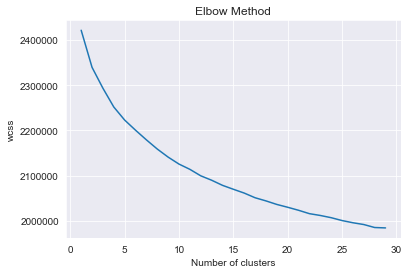

Time to plot: 2.8 mins


In [19]:
#k-means clustering
#Using the elbow method to find the optimum number of clusters
# what are clustering best practices
from sklearn.cluster import KMeans
t = time()
wcss = []
k_size = 30
X = arrays1
for i in range(1,k_size):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,k_size),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()
print('Time to plot: {} mins'.format(round((time() - t) / 60, 2)))

In [20]:
##Fitting kmeans to the dataset with k=20
t = time()
km4=KMeans(n_clusters=20,init='k-means++', max_iter=300, n_init=10, random_state=0).fit(arrays1)
word_groups = km4.labels_
print('Time to cluster: {} mins'.format(round((time() - t) / 60, 2)))
word_groups.shape

Time to cluster: 0.11 mins


(8071,)

In [21]:
word_groups

array([17,  3, 17, ...,  1, 10, 17], dtype=int32)

In [208]:
#word_groups (original reference)
# array([17,  3, 17, ...,  1, 10, 17], dtype=int32)

array([17,  3, 17, ...,  1, 10, 17], dtype=int32)

In [23]:
#validate
df_val = pd.read_csv('procurement_word2vec_output.csv')
df_val.head()

,word_filters,word,is_target_word,proximity_score,x,y,cluster
0,engagement,engagement,1,1.000000,-0.284275,-1.313506,17
1,engagement,engage,0,0.585383,-0.278712,-1.312120,15
2,engagement,appointment,0,0.474929,-0.402741,-0.607738,17
3,engagement,appoint,0,0.440318,-0.204303,-1.295064,17
4,engagement,appointment_panel,0,0.410290,-0.174961,-1.282326,17


In [24]:
df_val2 = df_val[df_val.is_target_word == 1]
df_val2.shape

(8071, 7)

In [29]:
df_val3 = df_val2.cluster
df_val4 = df_val3.values
df_val4.shape, type(df_val3), type(df_val4)

((8071,), pandas.core.series.Series, numpy.ndarray)

In [30]:
df_val4

array([17,  3, 17, ...,  1, 10, 17])

In [33]:
sum(word_groups!=df_val4)

0

In [ ]:
# above validates that labels are as before

In [ ]:
# sep clusters

In [95]:
arrays1[0]

array([ 0.09126563,  0.7255868 , -1.3471901 , -1.0909548 ,  0.34919992,
        1.0822847 , -1.084403  , -1.3385063 ,  0.7563738 ,  0.48796862,
        0.344302  , -1.0252438 , -0.8671644 ,  0.6559993 , -1.5705607 ,
       -0.5531191 , -0.29960793, -0.50888276, -0.09787042,  2.5702703 ,
        0.7981826 ,  2.1373694 ,  0.98899496, -1.6408994 , -0.42293498,
       -0.3518059 ,  0.2850199 ,  1.250523  , -0.17510799, -1.31641   ,
       -0.8729622 ,  0.3773091 , -1.9680026 , -0.17014226,  1.1532493 ,
        0.2188068 ,  0.1333315 ,  1.0693104 , -1.570466  , -0.1905702 ,
       -0.7976965 , -1.1296706 ,  2.3591802 , -0.635985  , -0.06134282,
       -0.13340496, -0.8860129 ,  1.4007816 , -0.06271996, -0.1852639 ,
        0.30977625,  0.14256515, -0.6732282 ,  0.8552558 ,  0.73951423,
        0.3508649 , -1.0516058 ,  0.84817255,  2.2069879 ,  0.23499292,
        0.8336071 ,  0.38184112, -0.01565861,  0.18215702, -0.59894186,
       -0.27582255,  0.09885817,  0.61964464,  0.6132735 , -1.18

In [81]:
word_groups.shape[0]

8071

In [56]:
max(arrays1[0]), min(arrays1[0])

(2.5702703, -2.4526637)

In [106]:
# seperate clusters based on user feedback
clusters_to_review = [0, 1, 3, 4, 10, 12, 14, 15, 16, 17, 18, 19]
arrays_to_review = np.empty((0, 300), dtype='f')
check_list = []
index_list = []
for index in range(word_groups.shape[0]):
    if word_groups[index] in clusters_to_review:
        index_list.append(index) 
        check_list.append(word_groups[index])
        arrays_to_review = np.append(arrays_to_review, arrays1[index].reshape(1,300), axis=0)
    count=index
            
list(sorted(set(check_list))), len(check_list), arrays_to_review.shape, count

([0, 1, 3, 4, 10, 12, 14, 15, 16, 17, 18, 19], 5453, (5453, 300), 8070)

In [107]:
sum(arrays_to_review[0]==arrays1[0])

300

In [112]:
len(index_list), df_val3.head()

(5453, 0     17
 11     3
 22    17
 33    12
 44     9
 Name: cluster, dtype: int64)

In [125]:
from_csv = df_val3[df_val3.isin(clusters_to_review)].values
type(from_csv), from_csv.shape

(numpy.ndarray, (5453,))

In [127]:
new_grouping = np.array(check_list)
type(new_grouping), new_grouping.shape

(numpy.ndarray, (5453,))

In [130]:
sum(from_csv != new_grouping)

0

In [ ]:
#above confirms order is maintained before and after the subsetting. 

In [ ]:
# re cluster

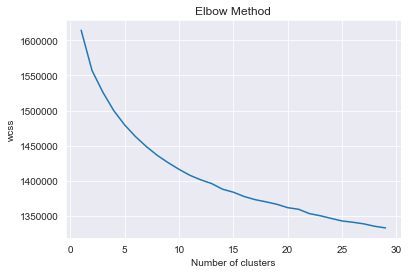

Time to plot: 1.72 mins


In [131]:
t = time()
wcss = []
k_size = 30
X = arrays_to_review
for i in range(1,k_size):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,k_size),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()
print('Time to plot: {} mins'.format(round((time() - t) / 60, 2)))

In [132]:
##Fitting kmeans to the dataset with k=20
t = time()
km4=KMeans(n_clusters=25,init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X)
word_groups = km4.labels_
print('Time to cluster: {} mins'.format(round((time() - t) / 60, 2)))
word_groups.shape

Time to cluster: 0.08 mins


(5453,)

In [137]:
min(word_groups), max(word_groups), word_groups

(0, 24, array([ 5,  8,  5, ..., 19, 18,  8], dtype=int32))

In [136]:
df_val2.shape

(8071, 7)

In [139]:
df_val5 = df_val2[df_val2.cluster.isin(clusters_to_review)][['cluster']]
df_val5.shape, df_val5.head()

((5453, 1),     cluster
 0        17
 11        3
 22       17
 33       12
 55       18)

In [141]:
df_val5['cluster_2']=word_groups.tolist()

In [144]:
df_val5.shape, df_val5.head()

((5453, 2),     cluster  cluster_2
 0        17          5
 11        3          8
 22       17          5
 33       12          2
 55       18         17)

In [150]:
df_val2.head(), df_val2.shape

(       word_filters             word  is_target_word  proximity_score  \
 0        engagement       engagement               1              1.0   
 11  video_recording  video_recording               1              1.0   
 22          service          service               1              1.0   
 33          seminar          seminar               1              1.0   
 44              jan              jan               1              1.0   
 
            x         y  cluster  
 0  -0.284275 -1.313506       17  
 11 -0.725028  0.790169        3  
 22 -0.316137  0.086545       17  
 33 -0.223347 -0.812216       12  
 44  0.329956 -1.925646        9  , (8071, 7))

In [157]:
df_val5.index

Int64Index([    0,    11,    22,    33,    55,    66,    88,    99,   121,
              132,
            ...
            88660, 88671, 88682, 88693, 88704, 88715, 88737, 88748, 88759,
            88770],
           dtype='int64', length=5453)

In [194]:
#left merge with original data, handle empty cells (merge by index)
df_val6 = pd.merge(df_val2[['word','x','y','cluster']], df_val5[['cluster_2']], how='left', left_index=True, right_index=True)
df_val6['cluster_2'].fillna(df_val6['cluster']+ 100, inplace=True)
df_val6['cluster_2'] = df_val6['cluster_2'].astype(int)
df_val6.head(20)

,word,x,y,cluster,cluster_2
0,engagement,-0.284275,-1.313506,17,5
11,video_recording,-0.725028,0.790169,3,8
22,service,-0.316137,0.086545,17,5
33,seminar,-0.223347,-0.812216,12,2
44,jan,0.329956,-1.925646,9,109
55,professional_service,0.401957,-0.873220,18,17
66,invitation_quote,-0.428136,-1.341517,3,5
77,supply,-0.437994,-1.375688,2,102
88,install,1.098431,0.707694,16,1
99,stainless_steel,1.188565,0.594820,4,1


In [195]:
df_val6.shape

(8071, 5)

In [196]:
for i in range(20):
    try:
        print(i, df_val6[df_val6.cluster==int(i)].groupby(['cluster_2']).size())
    except:
        print(i,'original cluster')

0 cluster_2
3       9
6      13
7     194
8       1
10     17
13      1
18      3
22      3
24      1
dtype: int64
1 cluster_2
3       2
5       2
6       3
8       1
10     48
13      1
15      3
18      9
19    248
22      1
23    112
24     26
dtype: int64
2 cluster_2
102    373
dtype: int64
3 cluster_2
1       5
3       5
4       1
5      17
8      29
10      6
11     62
13     13
14      8
15      1
16    188
18      3
21    119
22      5
dtype: int64
4 cluster_2
1     124
3       1
4      10
8       4
10      4
11     21
13      3
14    319
15      2
18     26
20     10
21      2
dtype: int64
5 cluster_2
105    354
dtype: int64
6 cluster_2
106    795
dtype: int64
7 cluster_2
107    325
dtype: int64
8 cluster_2
108    152
dtype: int64
9 cluster_2
109    119
dtype: int64
10 cluster_2
0       1
1       7
3       2
4       3
5       1
8       5
10     22
13      4
15    122
18     98
19      2
20    254
22      2
23      2
24      1
dtype: int64
11 cluster_2
111    290
dtype: int64
1

In [204]:
df_val6.groupby(['cluster_2']).size()

cluster_2
0      269
1      267
2      155
3      354
4      234
5      264
6       96
7      194
8      226
9       43
10     173
11     152
12     204
13     186
14     340
15     200
16     195
17     203
18     241
19     254
20     266
21     273
22     296
23     125
24     243
102    373
105    354
106    795
107    325
108    152
109    119
111    290
113    210
dtype: int64

In [205]:
df_val6.groupby(['cluster']).size()

cluster
0     242
1     456
2     373
3     462
4     526
5     354
6     795
7     325
8     152
9     119
10    526
11    290
12    292
13    210
14    485
15    412
16    487
17    661
18    258
19    646
dtype: int64

In [206]:
df_val.columns

Index(['word_filters', 'word', 'is_target_word', 'proximity_score', 'x', 'y',
       'cluster'],
      dtype='object')

In [207]:
df_val7 = df_val[['word_filters', 'word','is_target_word', 'proximity_score' ]]
df_val7.head()

,word_filters,word,is_target_word,proximity_score
0,engagement,engagement,1,1.000000
1,engagement,engage,0,0.585383
2,engagement,appointment,0,0.474929
3,engagement,appoint,0,0.440318
4,engagement,appointment_panel,0,0.410290


In [208]:
df_val7.shape, df_val7.shape[0]/11

((88781, 4), 8071.0)

In [209]:
#merge data set
df_val8 = pd.merge(df_val7, df_val6, how='left', on=['word'])
df_val8.head(20)

,word_filters,word,is_target_word,proximity_score,x,y,cluster,cluster_2
0,engagement,engagement,1,1.000000,-0.284275,-1.313506,17,5
1,engagement,engage,0,0.585383,-0.278712,-1.312120,15,0
2,engagement,appointment,0,0.474929,-0.402741,-0.607738,17,5
3,engagement,appoint,0,0.440318,-0.204303,-1.295064,17,5
4,engagement,appointment_panel,0,0.410290,-0.174961,-1.282326,17,5
5,engagement,provision,0,0.399386,-0.429126,-1.335253,14,5
6,engagement,established,0,0.378901,-0.442042,-0.618247,17,3
7,engagement,experienced,0,0.375268,-0.273309,-1.303774,2,102
8,engagement,hire,0,0.373792,-0.652784,-1.502036,2,102
9,engagement,chief,0,0.364937,-0.536283,-0.737849,17,3


In [210]:
df_val8.shape

(88781, 8)

In [211]:
df_val6[df_val6.word == 'provision']

,word,x,y,cluster,cluster_2
495,provision,-0.429126,-1.335253,14,5


In [212]:
# export to csv for tableau viz
df_val8.to_csv('procurement_word2vec_output_2.csv', index=False)

In [220]:
# explore misclassified words: infectious_disease, cancer
raw_df = pd.read_csv('procurement_enterprise_sg.csv')
raw_df.shape

(254315, 6)

In [201]:
#Dim Reduction
t = time()
# Use standard scalar on word vector arrays before dimensionality reduction
# why? read: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# arrays1 = StandardScaler().fit_transform(arrays)

# Reduces the dimensionality from 300 to 50 dimensions/ 0.999 of variance with PCA (use multiprocesser to speed up!)
# check for cpu utilization, perform multi threading
arrays2 = PCA(n_components= 50).fit_transform(arrays1)
print('Time to reduce dimensions from 300 to 50 via PCA: {} mins'.format(round((time() - t) / 60, 2)))

# Finds t-SNE coordinates for 2 dimensions
t= time()
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays2)

print('Time to reduce dimensions from 50 to 2 via TSNE: {} mins'.format(round((time() - t) / 60, 2)))

Y.shape

Time to reduce dimensions from 300 to 50 via PCA: 0.0 mins
Time to reduce dimensions from 50 to 2 via TSNE: 2.04 mins


(8071, 2)

In [202]:
np.std(Y), np.mean(Y)

(40.917217, 0.17246255)

In [203]:
Y_scaled = StandardScaler().fit_transform(Y)

In [204]:
np.std(Y_scaled), np.mean(Y_scaled)

(1.0000006, 7.56228e-09)

In [247]:
Y[0], Y_scaled[0]

(array([-10.743245, -56.62859 ], dtype=float32),
 array([-0.28427482, -1.3135056 ], dtype=float32))

In [249]:
x = Y_scaled[:, 0]
y = Y_scaled[:, 1]
x, y

(array([-0.28427482, -0.72502816, -0.31613693, ...,  1.863368  ,
         0.85093033, -0.28477088], dtype=float32),
 array([-1.3135056 ,  0.7901695 ,  0.08654512, ..., -0.10633091,
        -0.34168932,  0.1993682 ], dtype=float32))

In [250]:
# dataset for geography
df_words_geography = pd.DataFrame({'word': df_words_associations[df_words_associations.is_target_word == 1]['word'],
                   'x': x.tolist(),
                   'y': y.tolist(),
                   'cluster': word_groups.tolist()}).reset_index(drop=True)
df_words_geography.head()

,word,x,y,cluster
0,engagement,-0.284275,-1.313506,17
1,video_recording,-0.725028,0.790169,3
2,service,-0.316137,0.086545,17
3,seminar,-0.223347,-0.812216,12
4,jan,0.329956,-1.925646,9


In [232]:
df_words_geography.shape

(8071, 4)

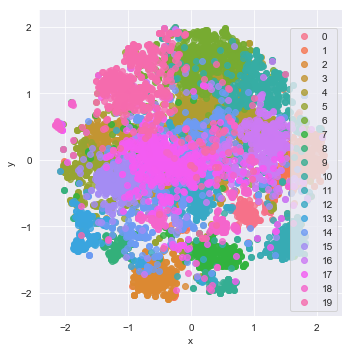

In [251]:
# Vizualize Clusters

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="x", y="y", data=df_words_geography, fit_reg=False, hue='cluster', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

In [220]:
t = time()
model = W2V_model
word_filters = []
word_labels = []
target_word  = []
proximity_score = []
count = 1.0

for word in model.wv.vocab:
#     print(word,'||','time_now:{} mins'.format(round((time() - t) / 60, 2)),'||', '{}% Completed'.format(round(100.0 * count / float(len(model.wv.vocab)))))
    # adds the vector of the query word
    word_filters.append(word)
    word_labels.append(word)
    target_word.append(1)
    proximity_score.append(1.0)

    # gets list of most similar words (seperate analysis for others: capture top 50)
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        word_filters.append(word)
        word_labels.append(wrd_score[0])
        target_word.append(0)
        proximity_score.append(wrd_score[1])
    
    count += 1
    

print('Time to build top similarity frame: {} mins'.format(round((time() - t) / 60, 2)))
print(count, len(word_labels), len(target_word), len(proximity_score))

Time to build top similarity frame: 0.17 mins
8072.0 88781 88781 88781


In [227]:
# dataset for associations
df_words_associations = pd.DataFrame({'word_filters': word_filters,
                   'word': word_labels,
                   'is_target_word': target_word,
                   'proximity_score': proximity_score})
df_words_associations.head(20)

,word_filters,word,is_target_word,proximity_score
0,engagement,engagement,1,1.000000
1,engagement,engage,0,0.585383
2,engagement,appointment,0,0.474929
3,engagement,appoint,0,0.440318
4,engagement,appointment_panel,0,0.410290
5,engagement,provision,0,0.399386
6,engagement,established,0,0.378901
7,engagement,experienced,0,0.375268
8,engagement,hire,0,0.373792
9,engagement,chief,0,0.364937


In [228]:
df_words_associations.shape

(88781, 4)

In [252]:
#merge data set
df_full = pd.merge(df_words_associations, df_words_geography, how='left', on=['word'])
df_full.head(20)

,word_filters,word,is_target_word,proximity_score,x,y,cluster
0,engagement,engagement,1,1.000000,-0.284275,-1.313506,17
1,engagement,engage,0,0.585383,-0.278712,-1.312120,15
2,engagement,appointment,0,0.474929,-0.402741,-0.607738,17
3,engagement,appoint,0,0.440318,-0.204303,-1.295064,17
4,engagement,appointment_panel,0,0.410290,-0.174961,-1.282326,17
5,engagement,provision,0,0.399386,-0.429126,-1.335253,14
6,engagement,established,0,0.378901,-0.442042,-0.618247,17
7,engagement,experienced,0,0.375268,-0.273309,-1.303774,2
8,engagement,hire,0,0.373792,-0.652784,-1.502036,2
9,engagement,chief,0,0.364937,-0.536283,-0.737849,17


In [255]:
df_full.shape, df_full.shape[0]/11

((88781, 7), 8071.0)

In [254]:
df_full[df_full.word == 'engage']

,word_filters,word,is_target_word,proximity_score,x,y,cluster
1,engagement,engage,0,0.585383,-0.278712,-1.31212,15
2651,engage,engage,1,1.000000,-0.278712,-1.31212,15
2754,provide,engage,0,0.406853,-0.278712,-1.31212,15
3305,conduct,engage,0,0.442023,-0.278712,-1.31212,15
6584,seek,engage,0,0.422268,-0.278712,-1.31212,15
7251,look,engage,0,0.477299,-0.278712,-1.31212,15
8560,experienced,engage,0,0.505170,-0.278712,-1.31212,15
8582,hire,engage,0,0.409040,-0.278712,-1.31212,15
11937,engage_vendor,engage,0,0.456088,-0.278712,-1.31212,15
12940,qualified,engage,0,0.452615,-0.278712,-1.31212,15


In [256]:
# export to csv for tableau viz
df_full.to_csv('procurement_word2vec_output.csv', index=False)

**t-SNE visualizations:**<br>
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [282]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [63]:
model = W2V_model
word = 'homer'
list_names = ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff']


arrays = np.empty((0, 300), dtype='f')
word_labels = [word]
color_list  = ['red']

# adds the vector of the query word
arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

# gets list of most similar words
close_words = model.wv.most_similar([word])

# adds the vector for each of the closest words to the array
for wrd_score in close_words:
    wrd_vector = model.wv.__getitem__([wrd_score[0]])
    word_labels.append(wrd_score[0])
    color_list.append('blue')
    arrays = np.append(arrays, wrd_vector, axis=0)

# adds the vector for each of the words from list_names to the array
for wrd in list_names:
    wrd_vector = model.wv.__getitem__([wrd])
    word_labels.append(wrd)
    color_list.append('green')
    arrays = np.append(arrays, wrd_vector, axis=0)

print(type(arrays), arrays.shape)
# Reduces the dimensionality from 300 to 50 dimensions with PCA
# reduc = PCA(n_components=50).fit_transform(arrays)


<class 'numpy.ndarray'> (19, 300)


PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [64]:
reduc = PCA(n_components= 0.999).fit_transform(arrays)

In [65]:
reduc.shape

(19, 17)

t-SNE: https://www.datacamp.com/community/tutorials/introduction-t-sne

In [66]:
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

In [67]:
Y.shape

(19, 2)

Our goal in this section is **to plot our 300 dimensions vectors into 2 dimensional graphs**, and see if we can spot interesting patterns.

For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color=red>**red**</font>), its most similar words in the model (in <font color=blue>**blue**</font>), and other words from the vocabulary (in <font color=green>**green**</font>).

In [283]:
def tsnescatterplot(model, word, list_names, pca):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    proximity_score = [1.0]
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        proximity_score.append(wrd_score[1])
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        proximity = model.wv.similarity(word, wrd)
        proximity_score.append(proximity)
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    if pca == 1:
        reduc = PCA(n_components= 0.999).fit_transform(arrays)
    else:
        reduc = arrays
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'score': proximity_score,
                       'color': color_list})
    print(df)
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

**10 Most similar words vs. 8 Random words:**<br>
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

             x           y                    words     score  color
0   185.629364  -56.813095         event_management  1.000000    red
1    48.095764  217.493240                    event  0.604570   blue
2    84.772964 -174.066895          event_organiser  0.565624   blue
3    24.025717  -26.684410          organise_manage  0.535963   blue
4   -63.354126 -139.432205               ordination  0.494491   blue
5  -122.079811  242.118164         opening_ceremony  0.491964   blue
6   115.552284   81.557503                logistics  0.482123   blue
7   -35.487621 -320.394226                 logistic  0.467247   blue
8  -142.814850  -26.142900       planning_execution  0.463420   blue
9  -201.732803 -199.952408       logistical_support  0.463290   blue
10 -198.192505  104.351952  marketing_communication  0.459709   blue
11 -339.421082  -28.578300               instructor -0.056656  green
12  316.783844  161.819717           junior_college  0.016747  green
13  -43.733265   97.592293        

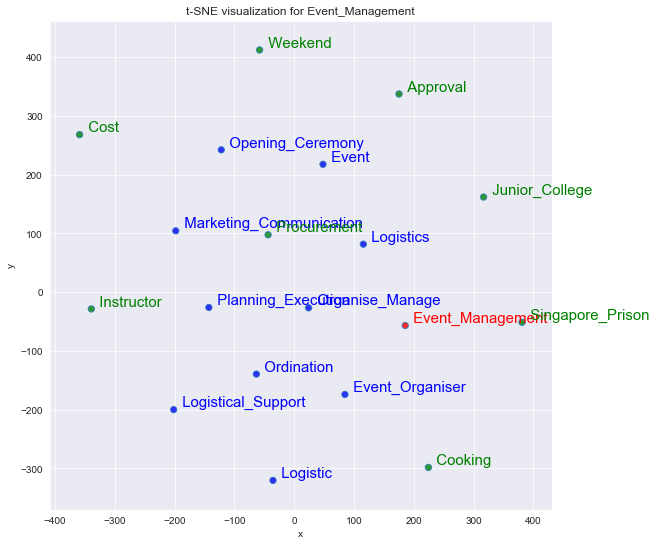

In [289]:
tsnescatterplot(W2V_model, 'event_management', ['instructor', 'junior_college', 'procurement', 'singapore_prison', 'cooking', 'approval', 'weekend', 'cost'],1)

**10 Most similar words vs. 10 Most dissimilar**<br>
This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

             x           y                       words     score  color
0   103.344894   39.844952                  instructor  1.000000    red
1   134.567307  102.621071                       coach  0.740094   blue
2   163.151459   32.839382                   programme  0.681479   blue
3    25.234589   44.584953                   instuctor  0.673102   blue
4    67.397232   95.111740                         cca  0.645780   blue
5   197.610031  -31.219900                  coach_week  0.593268   blue
6    50.603012   -6.326497                  curricular  0.577145   blue
7    94.949821  159.730469              main_assistant  0.569617   blue
8   116.423698  -37.860626       professional_coaching  0.560481   blue
9    15.488900  135.527084                cca_training  0.556571   blue
10  207.668762   82.303093        enrichment_programme  0.556158   blue
11   -6.749162 -103.612022                         ahu -0.389339  green
12 -106.103188  -27.940228                      system -0.375535

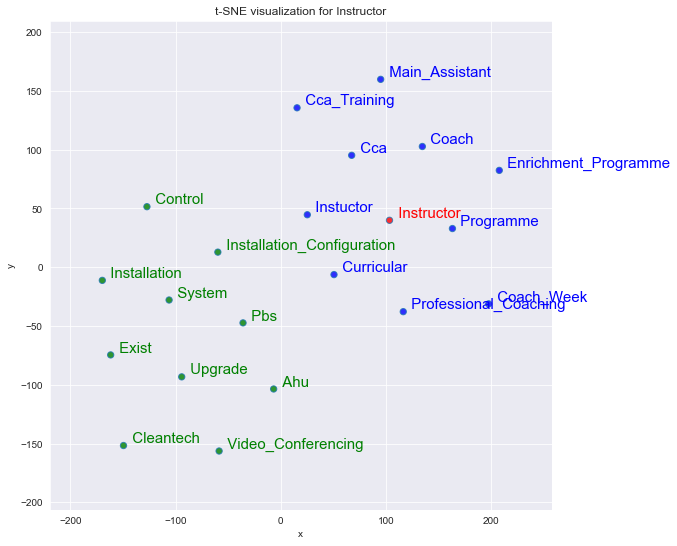

In [293]:
# highlight importance of quality: instuctor as misspelling
tsnescatterplot(W2V_model, 'instructor', [i[0] for i in W2V_model.wv.most_similar(negative=["instructor"])], 1)

**10 Most similar words vs. 11th to 20th Most similar words:** <br>
Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

(PS: Mr. Burns became mr_burn after the preprocessing)

             x           y                  words     score  color
0  -204.750519   -9.737394                cooking  1.000000    red
1    95.736740  -45.568943                   cook  0.599212   blue
2   -22.043585  -80.720161       bonding_activity  0.542964   blue
3  -127.225311   85.438881                 baking  0.502312   blue
4  -171.814865 -136.305206               trekking  0.471709   blue
5    40.557739  192.445923         food_nutrition  0.454358   blue
6  -109.011032  -60.853573          staff_bonding  0.453071   blue
7  -116.299850  179.764084                   bake  0.448189   blue
8    26.969305 -157.142136              orienteer  0.431188   blue
9   -75.587929 -149.045639              paintball  0.427916   blue
10  169.786118   69.497528             ingredient  0.425024   blue
11  120.972221  251.348862          home_economic  0.420910  green
12  109.812447  147.845917                    fce  0.417946  green
13  195.497925  179.447052          food_consumer  0.415679  g

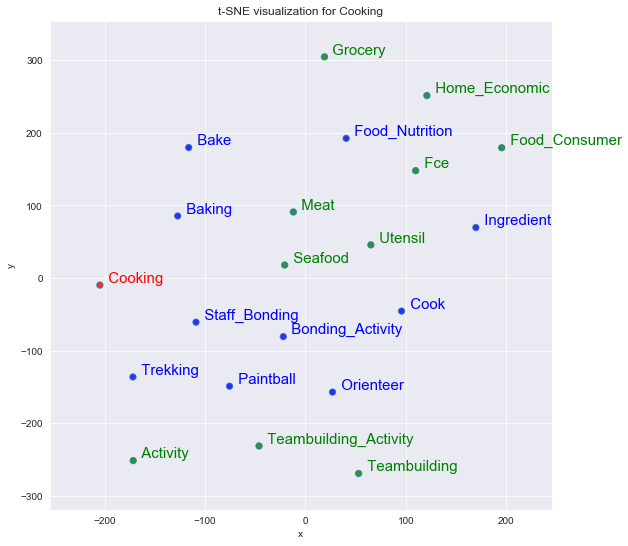

In [295]:
tsnescatterplot(W2V_model, "cooking", [t[0] for t in W2V_model.wv.most_similar(positive=["cooking"], topn=20)][10:],1)

**Create Dataframe for Tableau Viz** <br>

Df to contain the following columns:
    1. word
    2. X-coordinate
    3. Y-coordinate
    4. Target word (boolean)
    5. Proximity score of Neighbour word in relation to Target word
    6. Procurement segment
    7. Cluster

In [296]:
model = W2V_model
words = []
for word in model.wv.vocab: 
    words.append(word)
len(words)   

7849

In [303]:
t = time()

model = W2V_model
# word = 'homer'

arrays = np.empty((0, 300), dtype='f')
word_filters = []
word_labels = []
target_word  = []
proximity_score = []
count = 1.0
for word in model.wv.vocab:
    print(word,'||','time_now:{} mins'.format(round((time() - t) / 60, 2)),'||', '{}% Completed'.format(round(100.0 * count / float(len(model.wv.vocab)))))
    # adds the vector of the query word
    word_filters.append(word)
    word_labels.append(word)
    target_word.append(1)
    proximity_score.append(1.0)
    wrd_vector = model.wv.__getitem__([word])
    arrays = np.append(arrays, wrd_vector, axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        word_filters.append(word)
        word_labels.append(wrd_score[0])
        target_word.append(0)
        proximity_score.append(wrd_score[1])
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    count += 1
    
# Use standard scalar on word vector arrays before dimensionality reduction
# why? read: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# arrays = StandardScaler().fit_transform(arrays)

#cluster at 300 dimensions instead of 2 dimensions for better groups, then viz at 2d

# Reduces the dimensionality from 300 to 50 dimensions/ 0.999 of variance with PCA (use multiprocesser to speed up!)
# check for cpu utilization, perform multi threading
reduc = PCA(n_components= 50).fit_transform(arrays)

# Finds t-SNE coordinates for 2 dimensions
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
print(arrays.shape, len(word_labels), len(target_word), len(proximity_score))

df_words = pd.DataFrame({'word_filters': word_filters,
                   'word': word_labels,
                   'x': [x for x in Y[:, 0]],
                   'y': [y for y in Y[:, 1]],
                   'is_target_word': target_word,
                   'proximity_score': proximity_score})
df_words[df_words.word_filters == 'instructor']

engagement || time_now:0.0 mins || 0% Completed
video_recording || time_now:0.0 mins || 0% Completed
service || time_now:0.0 mins || 0% Completed
seminar || time_now:0.0 mins || 0% Completed
jan || time_now:0.0 mins || 0% Completed
invitation_quote || time_now:0.0 mins || 0% Completed
supply || time_now:0.0 mins || 0% Completed
install || time_now:0.0 mins || 0% Completed
stainless_steel || time_now:0.0 mins || 0% Completed
file || time_now:0.0 mins || 0% Completed
holder || time_now:0.0 mins || 0% Completed
inside || time_now:0.0 mins || 0% Completed
toilet || time_now:0.0 mins || 0% Completed
cubicle || time_now:0.0 mins || 0% Completed
malan || time_now:0.0 mins || 0% Completed
road || time_now:0.0 mins || 0% Completed
singapore || time_now:0.0 mins || 0% Completed
printing || time_now:0.0 mins || 0% Completed
delivery || time_now:0.0 mins || 0% Completed
moe || time_now:0.0 mins || 0% Completed
long || time_now:0.0 mins || 0% Completed
award || time_now:0.0 mins || 0% Completed
cer

emergency || time_now:0.03 mins || 2% Completed
officer || time_now:0.03 mins || 2% Completed
collection || time_now:0.03 mins || 2% Completed
datum_entry || time_now:0.03 mins || 2% Completed
project || time_now:0.03 mins || 2% Completed
computerised || time_now:0.03 mins || 2% Completed
adaptive || time_now:0.03 mins || 2% Completed
testing || time_now:0.03 mins || 2% Completed
illustration || time_now:0.03 mins || 2% Completed
preschool || time_now:0.03 mins || 2% Completed
english || time_now:0.03 mins || 3% Completed
mock || time_now:0.03 mins || 3% Completed
story_book || time_now:0.03 mins || 3% Completed
guideline || time_now:0.04 mins || 3% Completed
package || time_now:0.04 mins || 3% Completed
lower || time_now:0.04 mins || 3% Completed
malay || time_now:0.04 mins || 3% Completed
magazine || time_now:0.04 mins || 3% Completed
renewal || time_now:0.04 mins || 3% Completed
maintenance || time_now:0.04 mins || 3% Completed
fully_operational || time_now:0.04 mins || 3% Completed

chinese_dance || time_now:0.09 mins || 5% Completed
costume_syf || time_now:0.09 mins || 5% Completed
attachment_detail || time_now:0.09 mins || 5% Completed
hockey || time_now:0.09 mins || 5% Completed
cum || time_now:0.09 mins || 5% Completed
floorball_cca || time_now:0.09 mins || 5% Completed
boy || time_now:0.09 mins || 5% Completed
casuarina_primary || time_now:0.09 mins || 5% Completed
option || time_now:0.09 mins || 5% Completed
mission || time_now:0.09 mins || 5% Completed
girl || time_now:0.09 mins || 5% Completed
assistant || time_now:0.09 mins || 5% Completed
base || time_now:0.09 mins || 5% Completed
start || time_now:0.09 mins || 5% Completed
november || time_now:0.09 mins || 5% Completed
december || time_now:0.09 mins || 5% Completed
extend || time_now:0.09 mins || 5% Completed
refer || time_now:0.1 mins || 5% Completed
item || time_now:0.1 mins || 5% Completed
string || time_now:0.1 mins || 5% Completed
cello || time_now:0.1 mins || 5% Completed
bukit_view || time_now:0.

enrichment_programme || time_now:0.18 mins || 7% Completed
curricular_activity || time_now:0.18 mins || 7% Completed
chij_katong || time_now:0.18 mins || 7% Completed
choir_pianist || time_now:0.18 mins || 7% Completed
contemporary_dance || time_now:0.18 mins || 7% Completed
skip || time_now:0.18 mins || 7% Completed
recreational || time_now:0.18 mins || 7% Completed
bowling || time_now:0.18 mins || 7% Completed
tablet || time_now:0.18 mins || 7% Completed
management || time_now:0.18 mins || 7% Completed
cart || time_now:0.19 mins || 7% Completed
swimming || time_now:0.19 mins || 7% Completed
track_field || time_now:0.19 mins || 7% Completed
customize || time_now:0.19 mins || 7% Completed
river_valley || time_now:0.19 mins || 7% Completed
mathematic || time_now:0.19 mins || 7% Completed
low || time_now:0.19 mins || 7% Completed
estimate || time_now:0.19 mins || 7% Completed
upper || time_now:0.19 mins || 7% Completed
div || time_now:0.19 mins || 7% Completed
northland || time_now:0.19 

worksheet || time_now:0.3 mins || 9% Completed
exam || time_now:0.3 mins || 9% Completed
cod || time_now:0.3 mins || 9% Completed
password || time_now:0.3 mins || 9% Completed
tracking || time_now:0.3 mins || 9% Completed
purpose || time_now:0.3 mins || 9% Completed
refer_attachement || time_now:0.3 mins || 9% Completed
consideration || time_now:0.3 mins || 9% Completed
cyberwellness || time_now:0.3 mins || 9% Completed
content || time_now:0.3 mins || 9% Completed
facilitation || time_now:0.3 mins || 9% Completed
new_town || time_now:0.3 mins || 9% Completed
extension || time_now:0.3 mins || 9% Completed
xingnan_pri || time_now:0.31 mins || 9% Completed
speech || time_now:0.31 mins || 9% Completed
communication_skill || time_now:0.31 mins || 9% Completed
speaking || time_now:0.31 mins || 9% Completed
montfort_junior || time_now:0.31 mins || 9% Completed
ict_trainer || time_now:0.31 mins || 9% Completed
ict_executive || time_now:0.31 mins || 9% Completed
str_ensemble || time_now:0.31 mi

yearly_basis || time_now:0.48 mins || 11% Completed
provide_broadrick || time_now:0.48 mins || 11% Completed
monday || time_now:0.48 mins || 11% Completed
hrs || time_now:0.48 mins || 11% Completed
estimate_number || time_now:0.48 mins || 11% Completed
enrichment || time_now:0.48 mins || 11% Completed
generate || time_now:0.48 mins || 11% Completed
cad || time_now:0.48 mins || 11% Completed
final || time_now:0.49 mins || 11% Completed
presentation || time_now:0.49 mins || 11% Completed
board || time_now:0.49 mins || 11% Completed
rosyth || time_now:0.49 mins || 11% Completed
flute || time_now:0.49 mins || 11% Completed
evergreen || time_now:0.49 mins || 11% Completed
zhenghua || time_now:0.49 mins || 11% Completed
kindly_refer || time_now:0.49 mins || 11% Completed
specification_sheet || time_now:0.49 mins || 11% Completed
pioneer || time_now:0.49 mins || 11% Completed
sec_normal || time_now:0.5 mins || 12% Completed
technical || time_now:0.5 mins || 12% Completed
refer_attached || tim

declaration || time_now:0.64 mins || 13% Completed
form || time_now:0.65 mins || 13% Completed
price_proposal || time_now:0.65 mins || 13% Completed
doc || time_now:0.65 mins || 13% Completed
certify || time_now:0.65 mins || 14% Completed
qualification_experience || time_now:0.65 mins || 14% Completed
additional || time_now:0.65 mins || 14% Completed
organise_conduct || time_now:0.65 mins || 14% Completed
learning_journey || time_now:0.65 mins || 14% Completed
kampong_glam || time_now:0.65 mins || 14% Completed
creative_writing || time_now:0.66 mins || 14% Completed
guitar_ensemble || time_now:0.66 mins || 14% Completed
expect || time_now:0.66 mins || 14% Completed
come || time_now:0.66 mins || 14% Completed
tournament || time_now:0.66 mins || 14% Completed
assistance || time_now:0.66 mins || 14% Completed
thursday || time_now:0.66 mins || 14% Completed
chong || time_now:0.66 mins || 14% Completed
enquiry || time_now:0.66 mins || 14% Completed
desk_chair || time_now:0.67 mins || 14% Co

interview || time_now:0.84 mins || 16% Completed
etiquette_workshop || time_now:0.84 mins || 16% Completed
international_chess || time_now:0.84 mins || 16% Completed
instructional_coaching || time_now:0.85 mins || 16% Completed
till || time_now:0.85 mins || 16% Completed
whichev || time_now:0.85 mins || 16% Completed
serangoon_junior || time_now:0.85 mins || 16% Completed
draw || time_now:0.85 mins || 16% Completed
deyi_secondary || time_now:0.85 mins || 16% Completed
ingredient || time_now:0.85 mins || 16% Completed
practical_lesson || time_now:0.85 mins || 16% Completed
volleyball_girl || time_now:0.86 mins || 16% Completed
clay || time_now:0.86 mins || 16% Completed
sculpture || time_now:0.86 mins || 16% Completed
bedok_green || time_now:0.86 mins || 16% Completed
professional_coaching || time_now:0.86 mins || 16% Completed
marist || time_now:0.86 mins || 16% Completed
judo || time_now:0.86 mins || 16% Completed
inspire || time_now:0.86 mins || 16% Completed
wire_sculpture || time_n

facilitate || time_now:1.07 mins || 18% Completed
grand || time_now:1.07 mins || 18% Completed
finale || time_now:1.08 mins || 18% Completed
bear || time_now:1.08 mins || 18% Completed
associate || time_now:1.08 mins || 18% Completed
ethnic || time_now:1.08 mins || 18% Completed
fusion_dance || time_now:1.08 mins || 18% Completed
interdisciplinary || time_now:1.08 mins || 18% Completed
resident || time_now:1.08 mins || 18% Completed
administrator || time_now:1.09 mins || 18% Completed
bukit_merah || time_now:1.09 mins || 18% Completed
park_view || time_now:1.09 mins || 18% Completed
invite_vendor || time_now:1.09 mins || 18% Completed
ensemble_cca || time_now:1.09 mins || 18% Completed
literature_appreciation || time_now:1.09 mins || 18% Completed
oracy || time_now:1.1 mins || 18% Completed
cctv_surveillance || time_now:1.1 mins || 18% Completed
residential_ict || time_now:1.1 mins || 18% Completed
fernvale_primary || time_now:1.1 mins || 18% Completed
raise || time_now:1.1 mins || 18%

east_spring || time_now:1.34 mins || 20% Completed
nac_aep || time_now:1.34 mins || 20% Completed
endorse || time_now:1.34 mins || 20% Completed
space || time_now:1.34 mins || 20% Completed
fieldtrip || time_now:1.35 mins || 20% Completed
city || time_now:1.35 mins || 20% Completed
operation_support || time_now:1.35 mins || 20% Completed
female || time_now:1.35 mins || 20% Completed
strong || time_now:1.35 mins || 20% Completed
rhythmic_gymnastic || time_now:1.35 mins || 20% Completed
differentiate || time_now:1.36 mins || 20% Completed
grace || time_now:1.36 mins || 20% Completed
holistic || time_now:1.36 mins || 20% Completed
health || time_now:1.36 mins || 20% Completed
zone || time_now:1.36 mins || 20% Completed
dinner || time_now:1.36 mins || 20% Completed
softball_cca || time_now:1.36 mins || 20% Completed
scientific || time_now:1.37 mins || 20% Completed
concept || time_now:1.37 mins || 20% Completed
toy || time_now:1.37 mins || 20% Completed
questioning || time_now:1.37 mins ||

red || time_now:1.64 mins || 22% Completed
dot || time_now:1.64 mins || 22% Completed
reading_material || time_now:1.64 mins || 22% Completed
compilation || time_now:1.64 mins || 22% Completed
montage || time_now:1.65 mins || 22% Completed
conceptualisation_design || time_now:1.65 mins || 22% Completed
plate || time_now:1.65 mins || 22% Completed
door_access || time_now:1.65 mins || 22% Completed
control || time_now:1.65 mins || 22% Completed
geographic || time_now:1.66 mins || 22% Completed
explorer || time_now:1.66 mins || 22% Completed
entire || time_now:1.66 mins || 22% Completed
canon || time_now:1.66 mins || 22% Completed
duplex || time_now:1.66 mins || 22% Completed
toner || time_now:1.66 mins || 22% Completed
nature_reserve || time_now:1.67 mins || 22% Completed
responsible || time_now:1.67 mins || 22% Completed
fengshan || time_now:1.67 mins || 22% Completed
sungei_buloh || time_now:1.67 mins || 22% Completed
wetland_reserve || time_now:1.67 mins || 22% Completed
conducive || 

basic_enhanced || time_now:1.98 mins || 24% Completed
experienced_coach || time_now:1.98 mins || 24% Completed
opera || time_now:1.98 mins || 24% Completed
fri || time_now:1.98 mins || 24% Completed
morning || time_now:1.99 mins || 24% Completed
separately || time_now:1.99 mins || 24% Completed
insurance_policy || time_now:1.99 mins || 24% Completed
value || time_now:1.99 mins || 24% Completed
report || time_now:1.99 mins || 24% Completed
designer || time_now:2.0 mins || 24% Completed
bassoon || time_now:2.0 mins || 24% Completed
french || time_now:2.0 mins || 24% Completed
horn || time_now:2.0 mins || 24% Completed
saxophone || time_now:2.01 mins || 24% Completed
sajc || time_now:2.01 mins || 24% Completed
rest || time_now:2.01 mins || 24% Completed
christ_church || time_now:2.01 mins || 24% Completed
ukelele || time_now:2.01 mins || 24% Completed
prefect || time_now:2.02 mins || 25% Completed
lau || time_now:2.02 mins || 25% Completed
teo || time_now:2.02 mins || 25% Completed
hurdle

experiential_learning || time_now:2.35 mins || 26% Completed
aircon || time_now:2.36 mins || 26% Completed
attach_document || time_now:2.36 mins || 27% Completed
letter || time_now:2.36 mins || 27% Completed
explore || time_now:2.36 mins || 27% Completed
creativity || time_now:2.37 mins || 27% Completed
tentative || time_now:2.37 mins || 27% Completed
lee || time_now:2.37 mins || 27% Completed
cricket || time_now:2.37 mins || 27% Completed
african || time_now:2.37 mins || 27% Completed
plucking || time_now:2.38 mins || 27% Completed
lim || time_now:2.38 mins || 27% Completed
rock || time_now:2.38 mins || 27% Completed
wong || time_now:2.38 mins || 27% Completed
derrick || time_now:2.39 mins || 27% Completed
meal || time_now:2.39 mins || 27% Completed
ticket || time_now:2.39 mins || 27% Completed
south_korea || time_now:2.39 mins || 27% Completed
target || time_now:2.4 mins || 27% Completed
rehearsal || time_now:2.4 mins || 27% Completed
oral_presentation || time_now:2.4 mins || 27% Com

spice || time_now:2.79 mins || 29% Completed
orchid || time_now:2.79 mins || 29% Completed
butterfly_garden || time_now:2.79 mins || 29% Completed
weak || time_now:2.8 mins || 29% Completed
learner || time_now:2.8 mins || 29% Completed
koi_pond || time_now:2.8 mins || 29% Completed
frequency || time_now:2.8 mins || 29% Completed
nac_endorse || time_now:2.81 mins || 29% Completed
accompanist || time_now:2.81 mins || 29% Completed
track || time_now:2.81 mins || 29% Completed
dunman || time_now:2.81 mins || 29% Completed
tie || time_now:2.82 mins || 29% Completed
johor || time_now:2.82 mins || 29% Completed
malaysia || time_now:2.82 mins || 29% Completed
johor_malaysia || time_now:2.82 mins || 29% Completed
life_skill || time_now:2.83 mins || 29% Completed
sel || time_now:2.83 mins || 29% Completed
balance || time_now:2.83 mins || 29% Completed
career_guidance || time_now:2.83 mins || 29% Completed
talent || time_now:2.84 mins || 29% Completed
inventor || time_now:2.84 mins || 29% Complet

yrs || time_now:3.3 mins || 31% Completed
boom || time_now:3.31 mins || 31% Completed
studio || time_now:3.31 mins || 31% Completed
pilot || time_now:3.31 mins || 31% Completed
practitioner || time_now:3.31 mins || 31% Completed
cooking || time_now:3.32 mins || 31% Completed
battery_pack || time_now:3.32 mins || 31% Completed
adapter || time_now:3.32 mins || 31% Completed
highly || time_now:3.32 mins || 31% Completed
committed || time_now:3.33 mins || 31% Completed
competent || time_now:3.33 mins || 31% Completed
accredit || time_now:3.33 mins || 31% Completed
association || time_now:3.34 mins || 31% Completed
late || time_now:3.34 mins || 31% Completed
tae || time_now:3.34 mins || 31% Completed
photocopy || time_now:3.34 mins || 31% Completed
draft || time_now:3.35 mins || 31% Completed
artistic || time_now:3.35 mins || 31% Completed
holiday || time_now:3.35 mins || 31% Completed
selection || time_now:3.35 mins || 31% Completed
choreography || time_now:3.36 mins || 31% Completed
home 

electric || time_now:3.9 mins || 33% Completed
cooker || time_now:3.9 mins || 33% Completed
oven || time_now:3.9 mins || 33% Completed
loh || time_now:3.91 mins || 33% Completed
ver || time_now:3.91 mins || 33% Completed
yih || time_now:3.91 mins || 33% Completed
wearable || time_now:3.91 mins || 33% Completed
cornet || time_now:3.92 mins || 33% Completed
fiction || time_now:3.92 mins || 33% Completed
restore || time_now:3.92 mins || 33% Completed
cam || time_now:3.92 mins || 33% Completed
lcd || time_now:3.93 mins || 33% Completed
ink_cartridge || time_now:3.93 mins || 33% Completed
salary || time_now:3.93 mins || 33% Completed
progamme || time_now:3.94 mins || 33% Completed
conceptualise_design || time_now:3.94 mins || 33% Completed
amis_register || time_now:3.94 mins || 33% Completed
newsletter || time_now:3.94 mins || 33% Completed
student_handbook || time_now:3.95 mins || 33% Completed
experiential || time_now:3.95 mins || 33% Completed
success || time_now:3.95 mins || 33% Complet

finance || time_now:4.52 mins || 35% Completed
print_bind || time_now:4.52 mins || 35% Completed
film || time_now:4.52 mins || 35% Completed
opera_estate || time_now:4.53 mins || 35% Completed
attain || time_now:4.53 mins || 35% Completed
emotional || time_now:4.53 mins || 35% Completed
situation || time_now:4.54 mins || 35% Completed
debating || time_now:4.54 mins || 35% Completed
small || time_now:4.54 mins || 35% Completed
weapon || time_now:4.54 mins || 35% Completed
recommend || time_now:4.55 mins || 35% Completed
costume_prop || time_now:4.55 mins || 35% Completed
cds || time_now:4.55 mins || 35% Completed
non_residential || time_now:4.56 mins || 35% Completed
brain || time_now:4.56 mins || 35% Completed
zoo || time_now:4.56 mins || 35% Completed
bird || time_now:4.57 mins || 35% Completed
edition || time_now:4.57 mins || 35% Completed
tile || time_now:4.57 mins || 35% Completed
august || time_now:4.57 mins || 35% Completed
effectively || time_now:4.58 mins || 35% Completed
measu

diversity || time_now:5.18 mins || 37% Completed
initial || time_now:5.18 mins || 37% Completed
marina_barrage || time_now:5.19 mins || 37% Completed
marina || time_now:5.19 mins || 37% Completed
financial || time_now:5.19 mins || 37% Completed
attachement || time_now:5.2 mins || 37% Completed
fringe || time_now:5.2 mins || 37% Completed
large || time_now:5.21 mins || 37% Completed
book_title || time_now:5.22 mins || 37% Completed
yuan || time_now:5.22 mins || 37% Completed
guan || time_now:5.23 mins || 37% Completed
cycling || time_now:5.23 mins || 38% Completed
photocopying || time_now:5.24 mins || 38% Completed
moe_labrador || time_now:5.24 mins || 38% Completed
fort_canning || time_now:5.25 mins || 38% Completed
hill || time_now:5.25 mins || 38% Completed
asian_civilisation || time_now:5.26 mins || 38% Completed
museum || time_now:5.27 mins || 38% Completed
trace || time_now:5.27 mins || 38% Completed
chan || time_now:5.28 mins || 38% Completed
lie || time_now:5.28 mins || 38% Comp

airport || time_now:6.27 mins || 40% Completed
sightseeing || time_now:6.28 mins || 40% Completed
flip || time_now:6.29 mins || 40% Completed
tamil || time_now:6.29 mins || 40% Completed
temp || time_now:6.3 mins || 40% Completed
children || time_now:6.3 mins || 40% Completed
vinyl || time_now:6.31 mins || 40% Completed
photograph || time_now:6.32 mins || 40% Completed
hang || time_now:6.32 mins || 40% Completed
mtl_fortnight || time_now:6.33 mins || 40% Completed
transformation || time_now:6.34 mins || 40% Completed
gel || time_now:6.34 mins || 40% Completed
electrophoresis || time_now:6.35 mins || 40% Completed
biology || time_now:6.36 mins || 40% Completed
zoological_garden || time_now:6.36 mins || 40% Completed
indoor_sport || time_now:6.37 mins || 40% Completed
lian || time_now:6.37 mins || 40% Completed
internationalisation || time_now:6.38 mins || 40% Completed
accompany_staff || time_now:6.39 mins || 40% Completed
lasallian || time_now:6.39 mins || 40% Completed
war || time_now

energy || time_now:7.34 mins || 42% Completed
zeb || time_now:7.34 mins || 42% Completed
bca_academy || time_now:7.35 mins || 42% Completed
advertising || time_now:7.36 mins || 42% Completed
agency || time_now:7.36 mins || 42% Completed
recruitment_advertisement || time_now:7.37 mins || 42% Completed
large_format || time_now:7.38 mins || 42% Completed
soil || time_now:7.39 mins || 42% Completed
scale || time_now:7.39 mins || 42% Completed
scanning || time_now:7.4 mins || 42% Completed
aerial || time_now:7.41 mins || 42% Completed
topographic || time_now:7.41 mins || 42% Completed
hardcopy || time_now:7.42 mins || 42% Completed
authority || time_now:7.43 mins || 42% Completed
onsite || time_now:7.43 mins || 42% Completed
firewall || time_now:7.44 mins || 42% Completed
log || time_now:7.45 mins || 42% Completed
analyzer || time_now:7.45 mins || 42% Completed
scope_work || time_now:7.46 mins || 42% Completed
tree || time_now:7.47 mins || 42% Completed
tuas || time_now:7.47 mins || 42% Com

air_conditioning || time_now:8.73 mins || 44% Completed
standby_generator || time_now:8.74 mins || 44% Completed
vulnerability || time_now:8.75 mins || 44% Completed
customer_relationship || time_now:8.75 mins || 44% Completed
ipad_equivalent || time_now:8.76 mins || 44% Completed
datum_plan || time_now:8.77 mins || 44% Completed
marketing || time_now:8.77 mins || 44% Completed
initiative || time_now:8.78 mins || 44% Completed
iso || time_now:8.79 mins || 44% Completed
iec || time_now:8.8 mins || 44% Completed
jtc || time_now:8.81 mins || 44% Completed
meeting || time_now:8.82 mins || 44% Completed
thing || time_now:8.83 mins || 44% Completed
adoption || time_now:8.84 mins || 44% Completed
trend || time_now:8.85 mins || 44% Completed
roadmap || time_now:8.85 mins || 44% Completed
disk || time_now:8.86 mins || 44% Completed
arm || time_now:8.86 mins || 44% Completed
thumb_drive || time_now:8.87 mins || 44% Completed
potential_vendor || time_now:8.88 mins || 44% Completed
itemised_cost |

biodiversity || time_now:10.23 mins || 46% Completed
waterway || time_now:10.24 mins || 46% Completed
lucky || time_now:10.25 mins || 46% Completed
leather || time_now:10.26 mins || 46% Completed
card_holder || time_now:10.27 mins || 46% Completed
hdb_hub || time_now:10.28 mins || 46% Completed
design_fabrication || time_now:10.29 mins || 46% Completed
steel || time_now:10.3 mins || 46% Completed
detection_underground || time_now:10.31 mins || 46% Completed
hardware_software || time_now:10.32 mins || 46% Completed
faulty || time_now:10.33 mins || 46% Completed
pressure || time_now:10.33 mins || 46% Completed
east_wing || time_now:10.34 mins || 46% Completed
woodland_neighbourhood || time_now:10.35 mins || 46% Completed
cctv || time_now:10.36 mins || 46% Completed
video_recorder || time_now:10.37 mins || 46% Completed
dvr || time_now:10.37 mins || 46% Completed
duct || time_now:10.39 mins || 46% Completed
familiarisation || time_now:10.39 mins || 46% Completed
cash || time_now:10.4 mins

tester || time_now:11.7 mins || 48% Completed
carpet || time_now:11.71 mins || 48% Completed
facial || time_now:11.72 mins || 48% Completed
therapy || time_now:11.73 mins || 48% Completed
site_round || time_now:11.73 mins || 48% Completed
chng || time_now:11.74 mins || 48% Completed
crd || time_now:11.75 mins || 48% Completed
rapid || time_now:11.76 mins || 48% Completed
prototyp || time_now:11.77 mins || 48% Completed
organising || time_now:11.78 mins || 48% Completed
teambuild || time_now:11.79 mins || 48% Completed
paintball || time_now:11.79 mins || 48% Completed
instant || time_now:11.8 mins || 48% Completed
rove || time_now:11.81 mins || 48% Completed
fax || time_now:11.82 mins || 48% Completed
quad || time_now:11.83 mins || 48% Completed
robot || time_now:11.83 mins || 48% Completed
bottle || time_now:11.84 mins || 48% Completed
collar_pin || time_now:11.85 mins || 48% Completed
annual_report || time_now:11.86 mins || 48% Completed
asean || time_now:11.87 mins || 48% Completed
s

ssi || time_now:13.47 mins || 50% Completed
lecture || time_now:13.49 mins || 50% Completed
outsource || time_now:13.5 mins || 50% Completed
harbour || time_now:13.52 mins || 50% Completed
pasir_panjang || time_now:13.54 mins || 50% Completed
terminal || time_now:13.56 mins || 50% Completed
carton || time_now:13.57 mins || 50% Completed
bottled_water || time_now:13.59 mins || 50% Completed
seab || time_now:13.61 mins || 50% Completed
surface || time_now:13.62 mins || 50% Completed
sun || time_now:13.63 mins || 50% Completed
voucher || time_now:13.65 mins || 50% Completed
mgs || time_now:13.66 mins || 50% Completed
logistical_support || time_now:13.67 mins || 50% Completed
audio_visual || time_now:13.69 mins || 50% Completed
ministry || time_now:13.7 mins || 50% Completed
communication_information || time_now:13.72 mins || 50% Completed
mci || time_now:13.73 mins || 50% Completed
old_hill || time_now:13.75 mins || 50% Completed
street_police || time_now:13.76 mins || 50% Completed
reque

face || time_now:15.67 mins || 52% Completed
remedial || time_now:15.69 mins || 52% Completed
paya_lebar || time_now:15.7 mins || 52% Completed
proposed || time_now:15.72 mins || 52% Completed
dog || time_now:15.75 mins || 52% Completed
mouse || time_now:15.76 mins || 52% Completed
spf || time_now:15.78 mins || 52% Completed
vision || time_now:15.8 mins || 52% Completed
statement || time_now:15.82 mins || 52% Completed
fuel || time_now:15.84 mins || 52% Completed
police_division || time_now:15.86 mins || 52% Completed
cantonment || time_now:15.87 mins || 52% Completed
manner || time_now:15.89 mins || 52% Completed
actor || time_now:15.91 mins || 53% Completed
lanyard || time_now:15.92 mins || 53% Completed
mechanical || time_now:15.94 mins || 53% Completed
fold || time_now:15.95 mins || 53% Completed
intelligence || time_now:15.97 mins || 53% Completed
assorted || time_now:15.98 mins || 53% Completed
coffee || time_now:16.0 mins || 53% Completed
milk || time_now:16.01 mins || 53% Compl

movie || time_now:18.02 mins || 54% Completed
interactive_digital || time_now:18.03 mins || 54% Completed
dark || time_now:18.05 mins || 54% Completed
planter || time_now:18.05 mins || 54% Completed
corridor || time_now:18.07 mins || 54% Completed
fluorescent || time_now:18.08 mins || 55% Completed
lead_light || time_now:18.09 mins || 55% Completed
fitting || time_now:18.1 mins || 55% Completed
nanyang_polytechnic || time_now:18.11 mins || 55% Completed
leak || time_now:18.12 mins || 55% Completed
mobile_device || time_now:18.13 mins || 55% Completed
resolve || time_now:18.14 mins || 55% Completed
arcgis || time_now:18.14 mins || 55% Completed
stackable || time_now:18.15 mins || 55% Completed
hotplate || time_now:18.16 mins || 55% Completed
stirrer || time_now:18.17 mins || 55% Completed
removal || time_now:18.18 mins || 55% Completed
air_handle || time_now:18.19 mins || 55% Completed
wash || time_now:18.2 mins || 55% Completed
machining || time_now:18.21 mins || 55% Completed
mda || t

bay || time_now:19.53 mins || 57% Completed
tower || time_now:19.53 mins || 57% Completed
finder || time_now:19.54 mins || 57% Completed
embed || time_now:19.54 mins || 57% Completed
chassi || time_now:19.54 mins || 57% Completed
extent || time_now:19.55 mins || 57% Completed
gsm || time_now:19.55 mins || 57% Completed
matt || time_now:19.56 mins || 57% Completed
separator || time_now:19.56 mins || 57% Completed
basement || time_now:19.57 mins || 57% Completed
simulation_software || time_now:19.57 mins || 57% Completed
cavity || time_now:19.58 mins || 57% Completed
accredited_checker || time_now:19.58 mins || 57% Completed
experimental || time_now:19.59 mins || 57% Completed
catchment || time_now:19.6 mins || 57% Completed
planning_area || time_now:19.61 mins || 57% Completed
dynamic || time_now:19.62 mins || 57% Completed
analog || time_now:19.63 mins || 57% Completed
horizontal || time_now:19.64 mins || 57% Completed
tube_furnace || time_now:19.64 mins || 57% Completed
addition_alter

partition || time_now:20.72 mins || 59% Completed
kick || time_now:20.73 mins || 59% Completed
adm || time_now:20.74 mins || 59% Completed
heat || time_now:20.75 mins || 59% Completed
potentiostat || time_now:20.75 mins || 59% Completed
galvanostat || time_now:20.76 mins || 59% Completed
purification_system || time_now:20.77 mins || 59% Completed
signboard || time_now:20.78 mins || 59% Completed
zhou || time_now:20.79 mins || 59% Completed
vector || time_now:20.8 mins || 59% Completed
capacitor || time_now:20.81 mins || 59% Completed
fan || time_now:20.82 mins || 59% Completed
audio_video || time_now:20.83 mins || 59% Completed
kvm || time_now:20.84 mins || 59% Completed
comsol || time_now:20.84 mins || 59% Completed
multiphysic || time_now:20.85 mins || 59% Completed
viscometer || time_now:20.86 mins || 59% Completed
spms_ntu || time_now:20.87 mins || 59% Completed
cbc || time_now:20.88 mins || 59% Completed
teach_lab || time_now:20.89 mins || 59% Completed
gas_chromatography || time_

air_conditioner || time_now:21.96 mins || 61% Completed
oer || time_now:21.97 mins || 61% Completed
juniper || time_now:21.98 mins || 61% Completed
loaner || time_now:21.99 mins || 61% Completed
usa || time_now:22.0 mins || 61% Completed
dimmer || time_now:22.01 mins || 61% Completed
incoming || time_now:22.02 mins || 61% Completed
cee || time_now:22.03 mins || 61% Completed
clamp || time_now:22.04 mins || 61% Completed
tic || time_now:22.05 mins || 61% Completed
cellular || time_now:22.06 mins || 61% Completed
ssd || time_now:22.07 mins || 61% Completed
samsung || time_now:22.08 mins || 61% Completed
weblogic || time_now:22.09 mins || 61% Completed
date_time || time_now:22.09 mins || 61% Completed
onwards || time_now:22.1 mins || 61% Completed
visualizer || time_now:22.11 mins || 61% Completed
tutorial_room || time_now:22.12 mins || 61% Completed
intellectual_property || time_now:22.13 mins || 61% Completed
national_library || time_now:22.13 mins || 61% Completed
board_nlb || time_now

chassis || time_now:23.23 mins || 63% Completed
rain || time_now:23.24 mins || 63% Completed
congress || time_now:23.25 mins || 63% Completed
chernct || time_now:23.26 mins || 63% Completed
vacuum_pump || time_now:23.27 mins || 63% Completed
stable || time_now:23.28 mins || 63% Completed
cell_culture || time_now:23.29 mins || 63% Completed
alliance || time_now:23.3 mins || 63% Completed
agilent || time_now:23.31 mins || 63% Completed
straight || time_now:23.32 mins || 63% Completed
samsung_galaxy || time_now:23.33 mins || 63% Completed
desk || time_now:23.34 mins || 63% Completed
dia || time_now:23.34 mins || 63% Completed
bidder || time_now:23.35 mins || 63% Completed
external_facade || time_now:23.35 mins || 63% Completed
sketchup || time_now:23.36 mins || 63% Completed
late_version || time_now:23.36 mins || 63% Completed
pip || time_now:23.37 mins || 63% Completed
pull || time_now:23.37 mins || 63% Completed
heating || time_now:23.38 mins || 63% Completed
segment || time_now:23.38 m

greet || time_now:24.73 mins || 65% Completed
revamp || time_now:24.74 mins || 65% Completed
business_continuity || time_now:24.75 mins || 65% Completed
walkie_talkie || time_now:24.76 mins || 65% Completed
youth_movement || time_now:24.77 mins || 65% Completed
paym || time_now:24.78 mins || 65% Completed
chingay || time_now:24.79 mins || 65% Completed
contingent || time_now:24.8 mins || 65% Completed
community_leadership || time_now:24.81 mins || 65% Completed
south_west || time_now:24.82 mins || 65% Completed
district || time_now:24.83 mins || 65% Completed
highlight || time_now:24.84 mins || 65% Completed
educate || time_now:24.85 mins || 65% Completed
conservation || time_now:24.86 mins || 65% Completed
alternative || time_now:24.87 mins || 65% Completed
console || time_now:24.88 mins || 65% Completed
south_buona || time_now:24.89 mins || 65% Completed
vista_road || time_now:24.9 mins || 65% Completed
code || time_now:24.91 mins || 65% Completed
short_message || time_now:24.92 mins

epson || time_now:26.29 mins || 67% Completed
sdc || time_now:26.3 mins || 67% Completed
functionality || time_now:26.3 mins || 67% Completed
better || time_now:26.31 mins || 67% Completed
access_control || time_now:26.31 mins || 67% Completed
northern || time_now:26.32 mins || 67% Completed
sentosa_cove || time_now:26.33 mins || 67% Completed
development_corporation || time_now:26.34 mins || 67% Completed
sri || time_now:26.35 mins || 67% Completed
john_island || time_now:26.36 mins || 67% Completed
road_drain || time_now:26.37 mins || 67% Completed
humanity || time_now:26.38 mins || 67% Completed
statutory || time_now:26.39 mins || 67% Completed
commission_unit || time_now:26.4 mins || 67% Completed
lid || time_now:26.41 mins || 67% Completed
tool_material || time_now:26.42 mins || 67% Completed
edible || time_now:26.43 mins || 67% Completed
padding || time_now:26.44 mins || 67% Completed
seven || time_now:26.45 mins || 67% Completed
erp || time_now:26.46 mins || 67% Completed
valida

france || time_now:27.93 mins || 69% Completed
sino || time_now:27.94 mins || 69% Completed
kindergarten || time_now:27.95 mins || 69% Completed
methodology || time_now:27.96 mins || 69% Completed
iphone || time_now:27.97 mins || 69% Completed
photographer || time_now:27.98 mins || 69% Completed
shopping_voucher || time_now:27.99 mins || 69% Completed
establishment || time_now:28.0 mins || 69% Completed
numeracy || time_now:28.01 mins || 69% Completed
education_cce || time_now:28.02 mins || 69% Completed
protocol || time_now:28.03 mins || 69% Completed
psychologist || time_now:28.04 mins || 69% Completed
psychological || time_now:28.05 mins || 69% Completed
token || time_now:28.06 mins || 69% Completed
statistic || time_now:28.07 mins || 69% Completed
datum_analysis || time_now:28.08 mins || 69% Completed
junior_chef || time_now:28.09 mins || 69% Completed
site_brief || time_now:28.11 mins || 69% Completed
confirmation || time_now:28.12 mins || 69% Completed
eligible || time_now:28.13 

resume || time_now:29.62 mins || 71% Completed
closing || time_now:29.63 mins || 71% Completed
bonding_activity || time_now:29.64 mins || 71% Completed
animate || time_now:29.65 mins || 71% Completed
ais || time_now:29.66 mins || 71% Completed
prom || time_now:29.67 mins || 71% Completed
apr_apr || time_now:29.69 mins || 71% Completed
qiao || time_now:29.7 mins || 71% Completed
partial || time_now:29.71 mins || 71% Completed
graduation_dinner || time_now:29.72 mins || 71% Completed
photo_take || time_now:29.72 mins || 72% Completed
frontier || time_now:29.73 mins || 72% Completed
grey || time_now:29.73 mins || 72% Completed
transactional_analysis || time_now:29.74 mins || 72% Completed
cpu || time_now:29.75 mins || 72% Completed
duly || time_now:29.75 mins || 72% Completed
vex || time_now:29.76 mins || 72% Completed
movable || time_now:29.76 mins || 72% Completed
gen_nbn || time_now:29.77 mins || 72% Completed
newsletter_issue || time_now:29.78 mins || 72% Completed
charge_cart || time

ngnbn_internet || time_now:31.42 mins || 73% Completed
freight || time_now:31.43 mins || 73% Completed
blade || time_now:31.44 mins || 74% Completed
healthy_lifestyle || time_now:31.45 mins || 74% Completed
autoclave || time_now:31.46 mins || 74% Completed
annex_cost || time_now:31.47 mins || 74% Completed
mental_health || time_now:31.48 mins || 74% Completed
blind || time_now:31.49 mins || 74% Completed
towel || time_now:31.51 mins || 74% Completed
sticky || time_now:31.52 mins || 74% Completed
planning_execution || time_now:31.53 mins || 74% Completed
starter_kit || time_now:31.54 mins || 74% Completed
download || time_now:31.55 mins || 74% Completed
diaphragm || time_now:31.56 mins || 74% Completed
diamond || time_now:31.57 mins || 74% Completed
blood || time_now:31.58 mins || 74% Completed
download_attach || time_now:31.59 mins || 74% Completed
carpark || time_now:31.6 mins || 74% Completed
jalan || time_now:31.61 mins || 74% Completed
jalan_bukit || time_now:31.63 mins || 74% Comp

self_contain || time_now:33.33 mins || 76% Completed
breathing_apparatus || time_now:33.34 mins || 76% Completed
diving || time_now:33.35 mins || 76% Completed
jetty || time_now:33.37 mins || 76% Completed
courtyard || time_now:33.38 mins || 76% Completed
reinstatement_work || time_now:33.39 mins || 76% Completed
carbon_dioxide || time_now:33.4 mins || 76% Completed
lime || time_now:33.41 mins || 76% Completed
lifesaving || time_now:33.43 mins || 76% Completed
wrist || time_now:33.44 mins || 76% Completed
transporter || time_now:33.45 mins || 76% Completed
hard_drive || time_now:33.46 mins || 76% Completed
threat || time_now:33.47 mins || 76% Completed
roller_blind || time_now:33.49 mins || 76% Completed
fast || time_now:33.5 mins || 76% Completed
forklift || time_now:33.51 mins || 76% Completed
corp || time_now:33.52 mins || 76% Completed
toyota || time_now:33.53 mins || 76% Completed
iden || time_now:33.54 mins || 76% Completed
intrusion || time_now:33.56 mins || 76% Completed
high_v

merchandise || time_now:35.25 mins || 78% Completed
storage_space || time_now:35.26 mins || 78% Completed
www || time_now:35.27 mins || 78% Completed
bra_basah || time_now:35.28 mins || 78% Completed
precinct || time_now:35.29 mins || 78% Completed
alarm || time_now:35.3 mins || 78% Completed
heritage_conservation || time_now:35.32 mins || 78% Completed
preservation || time_now:35.33 mins || 78% Completed
monument || time_now:36.57 mins || 78% Completed
esplanade || time_now:36.58 mins || 78% Completed
symbol || time_now:36.59 mins || 78% Completed
edulab || time_now:36.6 mins || 78% Completed
synergy || time_now:36.61 mins || 78% Completed
api || time_now:36.63 mins || 78% Completed
sony || time_now:36.64 mins || 78% Completed
bcm || time_now:36.65 mins || 78% Completed
vault || time_now:36.67 mins || 78% Completed
shelving || time_now:36.68 mins || 78% Completed
contractor_attend || time_now:36.7 mins || 78% Completed
ibm_spss || time_now:36.71 mins || 78% Completed
scanning_electron

pallet || time_now:112.56 mins || 80% Completed
chlorine || time_now:112.57 mins || 80% Completed
cooler || time_now:112.57 mins || 80% Completed
gauge || time_now:112.58 mins || 80% Completed
crest || time_now:112.59 mins || 80% Completed
sewerage || time_now:112.59 mins || 80% Completed
aeration || time_now:112.6 mins || 80% Completed
isolation || time_now:112.6 mins || 80% Completed
diffuser || time_now:112.61 mins || 80% Completed
sls || time_now:112.63 mins || 80% Completed
variable_salinity || time_now:112.64 mins || 80% Completed
vsp || time_now:112.65 mins || 80% Completed
rectify || time_now:112.67 mins || 80% Completed
spotlight || time_now:112.68 mins || 80% Completed
brigade || time_now:112.69 mins || 80% Completed
cardio_pulmonary || time_now:112.71 mins || 80% Completed
resuscitation_cpr || time_now:112.72 mins || 80% Completed
upcoming || time_now:112.72 mins || 80% Completed
peirce || time_now:112.73 mins || 80% Completed
microcontroller || time_now:112.74 mins || 80% C

consecutive || time_now:183.54 mins || 82% Completed
manga || time_now:183.55 mins || 82% Completed
semakau || time_now:183.55 mins || 82% Completed
tropical || time_now:183.56 mins || 82% Completed
christian || time_now:183.57 mins || 82% Completed
floorball_rink || time_now:183.57 mins || 82% Completed
acs || time_now:183.58 mins || 82% Completed
annex_scope || time_now:183.59 mins || 82% Completed
camp_moe || time_now:183.59 mins || 82% Completed
roundtable || time_now:183.6 mins || 82% Completed
flame || time_now:183.61 mins || 82% Completed
cmo || time_now:183.61 mins || 82% Completed
persuasive || time_now:183.62 mins || 82% Completed
qualified_experienced || time_now:183.63 mins || 82% Completed
princess_elizabeth || time_now:183.63 mins || 82% Completed
thread || time_now:183.64 mins || 82% Completed
quest || time_now:183.65 mins || 82% Completed
tent || time_now:183.65 mins || 82% Completed
wwps || time_now:183.66 mins || 82% Completed
contribution || time_now:183.66 mins || 8

islamic_hub || time_now:360.85 mins || 84% Completed
braddell_road || time_now:360.86 mins || 84% Completed
bread || time_now:360.87 mins || 84% Completed
maritime_port || time_now:360.87 mins || 84% Completed
manhole || time_now:360.88 mins || 84% Completed
ferry_terminal || time_now:360.89 mins || 84% Completed
lighthouse || time_now:360.89 mins || 84% Completed
seafarer || time_now:360.9 mins || 84% Completed
psa_building || time_now:360.91 mins || 84% Completed
orchard || time_now:360.91 mins || 84% Completed
hari_raya || time_now:360.92 mins || 84% Completed
charity || time_now:360.93 mins || 84% Completed
din || time_now:360.93 mins || 84% Completed
tamper || time_now:360.94 mins || 84% Completed
vital || time_now:360.95 mins || 84% Completed
cutter || time_now:360.96 mins || 84% Completed
foreign_government || time_now:360.96 mins || 84% Completed
tvet || time_now:360.97 mins || 84% Completed
oman || time_now:360.98 mins || 84% Completed
enforcement || time_now:360.98 mins || 84

ridge || time_now:392.12 mins || 86% Completed
residenc || time_now:392.13 mins || 86% Completed
prince_george || time_now:392.13 mins || 86% Completed
reinforce || time_now:392.14 mins || 86% Completed
liquid_chromatography || time_now:392.15 mins || 86% Completed
deposition || time_now:392.15 mins || 86% Completed
standing || time_now:392.16 mins || 86% Completed
circ || time_now:392.17 mins || 86% Completed
cel || time_now:392.17 mins || 86% Completed
palm || time_now:392.18 mins || 86% Completed
valley || time_now:392.19 mins || 86% Completed
aug_jul || time_now:485.98 mins || 86% Completed
rackmount || time_now:485.99 mins || 86% Completed
loading || time_now:486.0 mins || 86% Completed
aquatic || time_now:486.02 mins || 86% Completed
annually || time_now:486.03 mins || 86% Completed
fst || time_now:486.04 mins || 86% Completed
lettering || time_now:486.05 mins || 86% Completed
drone || time_now:486.07 mins || 86% Completed
hydroculture || time_now:486.08 mins || 86% Completed
lee

cac || time_now:487.5 mins || 88% Completed
prom_night || time_now:487.51 mins || 88% Completed
mindset || time_now:487.52 mins || 88% Completed
anniversary_celebration || time_now:487.53 mins || 88% Completed
yewhwee || time_now:487.54 mins || 88% Completed
collection_disposal || time_now:487.55 mins || 88% Completed
biohazard || time_now:487.55 mins || 88% Completed
fusionopolis || time_now:487.56 mins || 88% Completed
multiplex || time_now:487.57 mins || 88% Completed
bsl || time_now:487.58 mins || 88% Completed
gmp || time_now:487.58 mins || 88% Completed
blower || time_now:487.59 mins || 88% Completed
don || time_now:487.6 mins || 88% Completed
cashew || time_now:487.61 mins || 88% Completed
jalan_bahar || time_now:487.61 mins || 88% Completed
widening || time_now:487.62 mins || 88% Completed
wait || time_now:487.63 mins || 88% Completed
parcel || time_now:487.64 mins || 88% Completed
tenant || time_now:487.64 mins || 88% Completed
oracle_database || time_now:487.65 mins || 88% Co

toc || time_now:488.84 mins || 90% Completed
woodleigh || time_now:488.85 mins || 90% Completed
sungei || time_now:488.86 mins || 90% Completed
idd || time_now:488.87 mins || 90% Completed
waterhub || time_now:488.89 mins || 90% Completed
highway || time_now:488.89 mins || 90% Completed
disciplinary || time_now:488.91 mins || 90% Completed
abc_water || time_now:488.92 mins || 90% Completed
trip_taiwan || time_now:488.92 mins || 90% Completed
philippine || time_now:488.93 mins || 90% Completed
prove || time_now:488.94 mins || 90% Completed
liability || time_now:488.95 mins || 90% Completed
bte || time_now:488.96 mins || 90% Completed
sensitive || time_now:488.96 mins || 90% Completed
tourist_guide || time_now:488.97 mins || 90% Completed
erm || time_now:488.98 mins || 90% Completed
nitride || time_now:488.99 mins || 90% Completed
regatta || time_now:489.0 mins || 90% Completed
vendor_attend || time_now:489.0 mins || 90% Completed
investigation_work || time_now:489.01 mins || 90% Complet

nrf || time_now:490.24 mins || 92% Completed
nptd || time_now:490.25 mins || 92% Completed
pumping || time_now:490.26 mins || 92% Completed
temperature_sensor || time_now:490.27 mins || 92% Completed
assessor || time_now:490.28 mins || 92% Completed
arduino || time_now:490.28 mins || 92% Completed
kenneth || time_now:490.29 mins || 92% Completed
imager || time_now:490.3 mins || 92% Completed
mun || time_now:490.31 mins || 92% Completed
ling_tel || time_now:490.31 mins || 92% Completed
marathon || time_now:490.32 mins || 92% Completed
pol || time_now:490.33 mins || 92% Completed
aug_aug || time_now:490.34 mins || 92% Completed
sep_aug || time_now:490.35 mins || 92% Completed
loose_furniture || time_now:490.36 mins || 92% Completed
jiemin_primary || time_now:490.37 mins || 93% Completed
saint_andrew || time_now:490.38 mins || 93% Completed
suitability || time_now:490.39 mins || 93% Completed
olympic || time_now:490.4 mins || 93% Completed
awn || time_now:490.41 mins || 93% Completed
quan

joseph || time_now:491.66 mins || 94% Completed
fpga || time_now:491.67 mins || 94% Completed
empress_place || time_now:491.68 mins || 94% Completed
sysnmh || time_now:491.69 mins || 94% Completed
mid_autumn || time_now:491.7 mins || 94% Completed
simei || time_now:491.7 mins || 94% Completed
logistics || time_now:491.71 mins || 94% Completed
yong_loo || time_now:491.72 mins || 94% Completed
resurfacing || time_now:491.73 mins || 94% Completed
singlet || time_now:491.74 mins || 94% Completed
optomechanical || time_now:491.74 mins || 95% Completed
red_hat || time_now:491.75 mins || 95% Completed
tight || time_now:491.76 mins || 95% Completed
sigma || time_now:491.77 mins || 95% Completed
generation_sequencing || time_now:491.78 mins || 95% Completed
punggol_way || time_now:491.78 mins || 95% Completed
delta || time_now:491.79 mins || 95% Completed
shin || time_now:491.8 mins || 95% Completed
owner || time_now:491.81 mins || 95% Completed
vetting || time_now:491.82 mins || 95% Completed


resuscitation || time_now:492.99 mins || 96% Completed
competent_personnel || time_now:493.0 mins || 96% Completed
accelerometer || time_now:493.0 mins || 96% Completed
benchmarking || time_now:493.01 mins || 96% Completed
helper || time_now:493.02 mins || 96% Completed
waterfront || time_now:493.03 mins || 97% Completed
kwan || time_now:493.04 mins || 97% Completed
good_performance || time_now:493.04 mins || 97% Completed
pasir_crest || time_now:493.05 mins || 97% Completed
oasis || time_now:493.06 mins || 97% Completed
stone || time_now:493.07 mins || 97% Completed
cultural_society || time_now:493.08 mins || 97% Completed
clementi_pri || time_now:493.09 mins || 97% Completed
chij_sjc || time_now:493.09 mins || 97% Completed
disability || time_now:493.1 mins || 97% Completed
board_hpb || time_now:493.11 mins || 97% Completed
ipad_air || time_now:493.12 mins || 97% Completed
learning_sel || time_now:493.13 mins || 97% Completed
paul || time_now:493.14 mins || 97% Completed
secured || t

youth_celebrate || time_now:494.44 mins || 98% Completed
tkgs || time_now:494.45 mins || 98% Completed
apsc || time_now:494.46 mins || 98% Completed
bakery || time_now:494.47 mins || 98% Completed
medium_buying || time_now:494.48 mins || 99% Completed
ansys || time_now:494.49 mins || 99% Completed
checker_specialist || time_now:494.49 mins || 99% Completed
parkway || time_now:494.5 mins || 99% Completed
ost || time_now:494.51 mins || 99% Completed
fajar_secondary || time_now:494.52 mins || 99% Completed
family_justice || time_now:494.53 mins || 99% Completed
pbs || time_now:494.54 mins || 99% Completed
submission_require || time_now:494.55 mins || 99% Completed
document_disqualify || time_now:494.56 mins || 99% Completed
chian_natural || time_now:494.56 mins || 99% Completed
history_museum || time_now:494.57 mins || 99% Completed
senja || time_now:494.58 mins || 99% Completed
trcc || time_now:494.59 mins || 99% Completed
fathin || time_now:494.6 mins || 99% Completed
masud || time_now:

,word_filters,word,x,y,is_target_word,proximity_score
2695,instructor,instructor,23.017950,-58.584389,1,1.000000
2696,instructor,coach,-39.323475,27.008425,0,0.740094
2697,instructor,programme,-24.444551,-19.203176,0,0.681479
2698,instructor,instuctor,-27.540409,-19.591696,0,0.673102
2699,instructor,cca,44.243526,-26.941336,0,0.645780
2700,instructor,coach_week,24.436117,-62.109806,0,0.593268
2701,instructor,curricular,-27.232790,-17.880617,0,0.577145
2702,instructor,main_assistant,-56.943420,-0.129349,0,0.569617
2703,instructor,professional_coaching,45.420425,-27.150772,0,0.560481
2704,instructor,cca_training,26.412584,-61.163631,0,0.556571


In [ ]:
#     # Sets everything up to plot
#     df_words = pd.DataFrame({'x': [x for x in Y[:, 0]],
#                        'y': [y for y in Y[:, 1]],
#                        'words': word_labels,
#                        'color': color_list})

In [304]:
df_words.shape

(86339, 6)

In [3]:
# backup data since takes time to build it
df_words.to_csv('word_data_backup.csv', index=False)

NameError: name 'df_words' is not defined

In [4]:
# load backup data
df_words = pd.read_csv('word_data_backup.csv')
df_words.shape

(86339, 6)

In [5]:
df_words[df_words.is_target_word == 1].head(), df_words[df_words.is_target_word == 1].shape

(       word_filters             word          x          y  is_target_word  \
 0        engagement       engagement -28.758669 -31.968592               1   
 11  video_recording  video_recording   9.356383 -17.503933               1   
 22          service          service  -3.436201   4.617774               1   
 33          seminar          seminar -25.690077   7.927521               1   
 44              jan              jan   3.257982  35.656513               1   
 
     proximity_score  
 0               1.0  
 11              1.0  
 22              1.0  
 33              1.0  
 44              1.0  , (7849, 6))

In [6]:
df_cluster = df_words[df_words.is_target_word == 1][['word','x','y']].reset_index(drop= True)
df_cluster.head(), df_cluster.shape

(              word          x          y
 0       engagement -28.758669 -31.968592
 1  video_recording   9.356383 -17.503933
 2          service  -3.436201   4.617774
 3          seminar -25.690077   7.927521
 4              jan   3.257982  35.656513, (7849, 3))

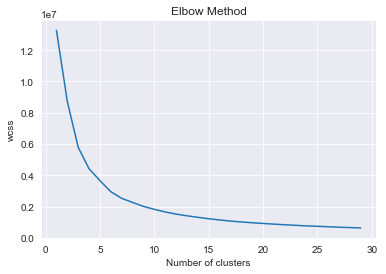

In [7]:
#Using the elbow method to find the optimum number of clusters
# what are clustering best practices
from sklearn.cluster import KMeans
wcss = []
k_size = 30
X = df_cluster[['x','y']]
for i in range(1,k_size):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,k_size),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [8]:
##Fitting kmeans to the dataset with k=6
km4=KMeans(n_clusters=10,init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X)
word_groups = km4.labels_ 
word_groups.shape

(7849,)

In [9]:
df_cluster['word_groups'] = word_groups.tolist()
df_cluster = df_cluster.sort_values(by='word_groups')
df_cluster.head()

,word,x,y,word_groups
3924,mpa,13.605468,-8.620141,0
6232,passionart,-3.263637,-18.896921,0
1123,hall,-0.757438,-29.684044,0
2670,spring,1.083142,0.116023,0
6237,gis,12.057223,-27.919287,0


In [10]:
df_cluster['word_groups'].value_counts()

2    1082
0     982
3     977
5     828
4     770
1     731
8     656
6     621
9     609
7     593
Name: word_groups, dtype: int64

In [11]:
clusters  = df_cluster['word_groups'].unique().tolist()

for cluster in clusters:
    print('*************','cluster 1:', cluster,'*************')
    print(df_cluster[df_cluster['word_groups'] == cluster].head(20))

************* cluster 1: 0 *************
                       word          x          y  word_groups
3924                    mpa  13.605468  -8.620141            0
6232             passionart  -3.263637 -18.896921            0
1123                   hall  -0.757438 -29.684044            0
2670                 spring   1.083142   0.116023            0
6237                    gis  12.057223 -27.919287            0
6239                    buy   6.643726  -1.315525            0
6243  presentation_ceremony   7.247446 -29.484671            0
2672           registration  11.263320 -21.455950            0
6245              guidebook   5.581363 -12.922363            0
2674                  score   2.078946  -2.377648            0
6252              recognise  -4.154928  -8.099331            0
6253            outstanding  -3.910610  -7.423844            0
2682                 domain  16.094955  -9.294956            0
6277                    sls  -9.983405 -11.392632            0
4124          

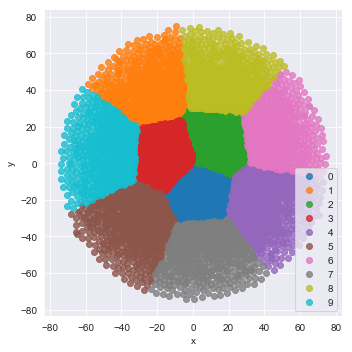

In [12]:
# Vizualize Clusters

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="x", y="y", data=df_cluster, fit_reg=False, hue='word_groups', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

In [13]:
df_cluster.shape

(7849, 4)

In [14]:
df_cluster[df_cluster.word_groups == 2].tail(5)

,word,x,y,word_groups
4921,winch,16.392988,17.326340,2
7576,good_performance,0.613777,8.638608,2
193,testing,17.657471,-2.563601,2
5664,border,4.838978,4.042942,2
1527,slip,13.863191,15.075146,2


**Zoom in to discover cluster groups and words**

In [325]:
# func with optional parameter: https://hackernoon.com/python-functions-args-kwargs-5d2d00f09c74
def plot_region(x_bounds, y_bounds, **kwargs):
    
    if args:
        cluster = args[0]
        points = df_cluster[df_cluster.word_groups == cluster]
    
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", #c= 'word_groups', colormap='viridis', 
                            s=35, figsize=(20, 16))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [372]:
max(df_cluster.x)

74.36079406738281

In [20]:
# func with optional parameter: https://hackernoon.com/python-functions-args-kwargs-5d2d00f09c74
def plot_region(**kwargs):
    
    #set base dataset
    points = df_cluster
    
    #set flags
    x_exists = 0
    y_exists = 0
    
    for key, value in kwargs.items():
#         print("The value of {} is {}".format(key, value))
        
        # segment by cluster
        if key == 'cluster':
            points = points[points.word_groups == value]                  
        
        # bound by x
        if key == 'x_bounds':
            x_exists = 1
            lower_x_bound = value[0]
            upper_x_bound = value[1]       

        # bound by y
        if key == 'y_bounds':
            y_exists = 1
            lower_y_bound = value[0]
            upper_y_bound = value[1]
            
    # if no x bounds provided
    if x_exists == 0:
        lower_x_bound = min(points.x) - 1.0
        upper_x_bound = max(points.x) + 1.0
    
    # if no y bounds provided
    if y_exists == 0:
        lower_y_bound = min(points.y) - 1.0 
        upper_y_bound = max(points.y) + 1.0        
     
#     print('after cluster:', points.head(), points.shape)
#     print('x:', lower_x_bound, upper_x_bound)
#     print('y:', lower_y_bound, upper_y_bound)

    # bound dataset
    slice = points[
            (lower_x_bound <= points.x) &
            (points.x <= upper_x_bound) & 
            (lower_y_bound <= points.y) &
            (points.y <= upper_y_bound)
            ]
#     print('after bounding:', slice.head(), slice.shape)
    
    # plot
    ax = slice.plot.scatter("x", "y", #c= 'word_groups', colormap='viridis', 
                            s=100, figsize=(20, 16))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

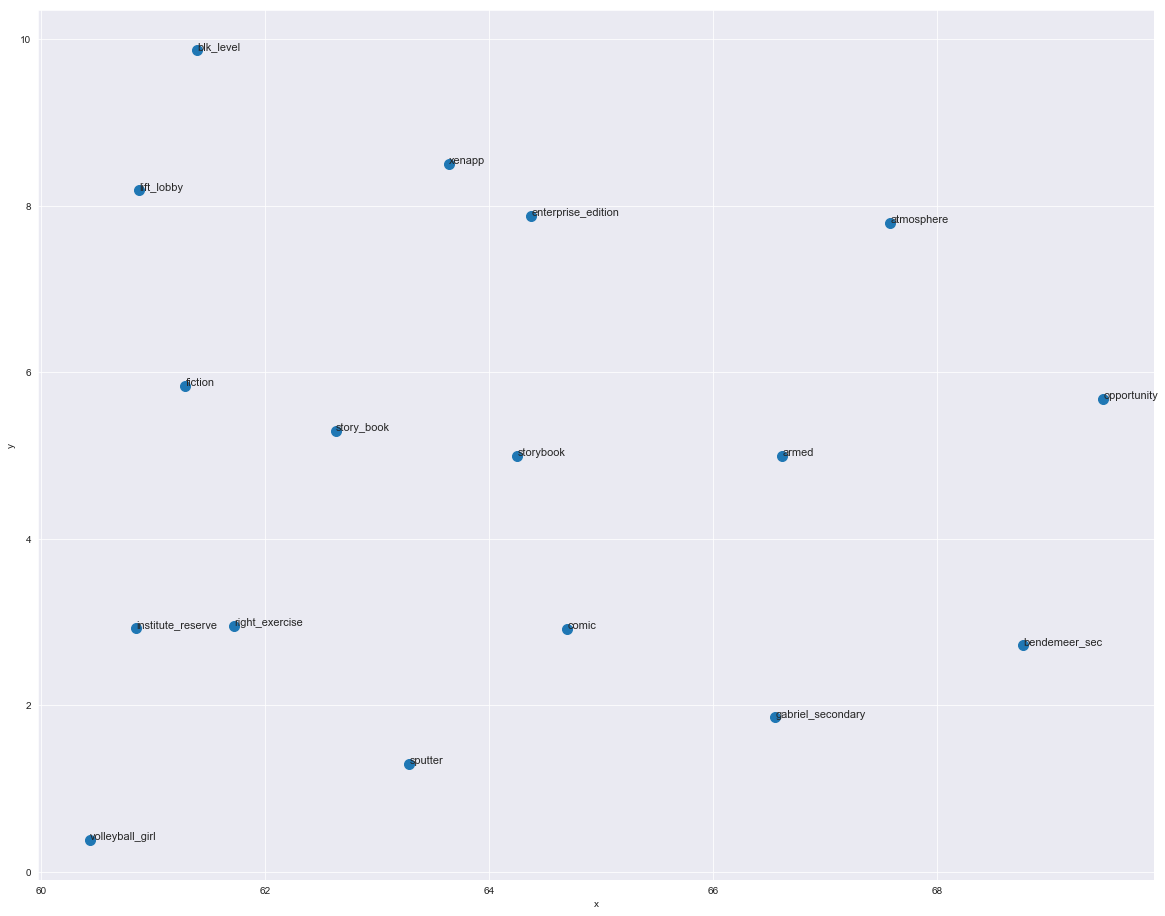

In [21]:
# 1st: which cluster? 2nd: x range? 3rd: y range?
plot_region(cluster =6, x_bounds=(60,70),y_bounds=(0,10))

**Merge Data**

In [33]:
df_words.shape, df_cluster.shape

((86339, 6), (7849, 4))

In [34]:
df_full = pd.merge(df_words, df_cluster[['word','word_groups']], how='left', on=['word'])

In [36]:
df_full.shape, df_full.head()

((86339, 7),
   word_filters               word          x          y  is_target_word  \
 0   engagement         engagement -28.758669 -31.968592               1   
 1   engagement             engage -28.328175 -31.912327               0   
 2   engagement            appoint -39.887165  15.336481               0   
 3   engagement        appointment -25.168325  12.825706               0   
 4   engagement  appointment_panel -40.149910  16.621517               0   
 
    proximity_score  word_groups  
 0         1.000000            5  
 1         0.642953            5  
 2         0.448057            9  
 3         0.439035            3  
 4         0.433022            9  )

,word_filters,word,x,y,is_target_word,proximity_score,word_groups
2695,instructor,instructor,23.017950,-58.584389,1,1.000000,7
2696,instructor,coach,-39.323475,27.008425,0,0.740094,1
2697,instructor,programme,-24.444551,-19.203176,0,0.681479,5
2698,instructor,instuctor,-27.540409,-19.591696,0,0.673102,5
2699,instructor,cca,44.243526,-26.941336,0,0.645780,4
2700,instructor,coach_week,24.436117,-62.109806,0,0.593268,7
2701,instructor,curricular,-27.232790,-17.880617,0,0.577145,5
2702,instructor,main_assistant,-56.943420,-0.129349,0,0.569617,9
2703,instructor,professional_coaching,45.420425,-27.150772,0,0.560481,4
2704,instructor,cca_training,26.412584,-61.163631,0,0.556571,7


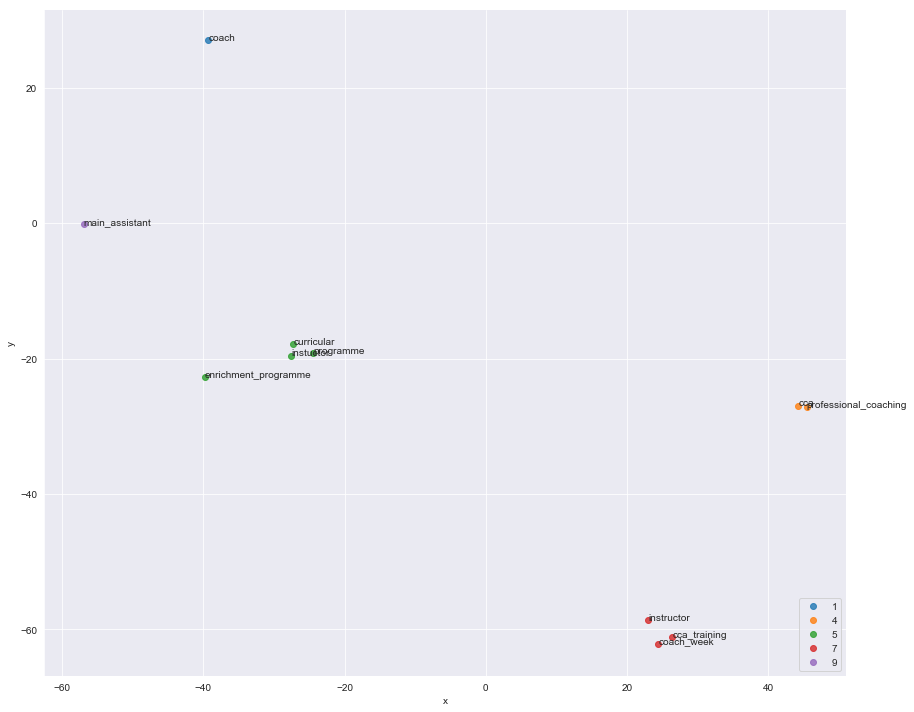

In [64]:
# Use the 'hue' argument to provide a factor variable
filter_word = 'instructor'
test_data = df_full[df_full.word_filters == filter_word]

# sns plot
ax = sns.lmplot( x="x", y="y", data=test_data, fit_reg=False, hue='word_groups', legend= False,
               height=10, aspect=1.2) 

# add labels
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.02, str(point['val']), size = 10)

label_point(test_data.x, test_data.y, test_data.word, plt.gca())
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

# plot
# ax = test_data.plot.scatter("x", "y", c= 'word_groups', legend='viridis', 
#                         s=35, figsize=(20, 16))
# for i, point in test_data.iterrows():
#     ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
# ax.legend()

test_data

**Cosine Similarity Vs. Euclidean Distance** 

https://cmry.github.io/notes/euclidean-v-cosine

In [ ]:
marge = [54.906185 , -9.140314]
terrific = [-3.189991, 20.440323]
homer = [-57.232517, 56.169361]

In [ ]:
def l2_norm(marge):
    marge_l2 = np.sqrt(marge[0]**2 + marge[1]**2)
    marge_norm = marge/marge_l2
    return marge_norm

marge_norm = l2_norm(marge)
terrific_norm = l2_norm(terrific)
homer_norm = l2_norm(homer)

marge_norm, terrific_norm, homer_norm

In [ ]:
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))
euclidean_distance(marge_norm, homer_norm), euclidean_distance(terrific_norm, homer_norm)

In [ ]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
cosine_similarity(marge_norm, homer_norm), cosine_similarity(terrific_norm, homer_norm)

In [ ]:
def l1_normalize(v):
    norm = np.sum(v)
    return v / norm

marge_norm = l1_normalize(marge)
terrific_norm = l1_normalize(terrific)
homer_norm = l1_normalize(homer)
marge_norm, homer_norm, terrific_norm

In [ ]:
cosine_similarity(marge_norm, homer_norm), cosine_similarity(terrific_norm, homer_norm)

In [ ]:
euclidean_distance(marge_norm, homer_norm), euclidean_distance(terrific_norm, homer_norm)

In [ ]:
def l2_normalize(v):
    norm = np.sqrt(np.sum(np.square(v)))
    return v / norm

marge_norm = l2_normalize(marge)
terrific_norm = l2_normalize(terrific)
homer_norm = l2_normalize(homer)
marge_norm, homer_norm, terrific_norm

In [ ]:
cosine_similarity(marge_norm, homer_norm), cosine_similarity(terrific_norm, homer_norm)

In [ ]:
euclidean_distance(marge_norm, homer_norm), euclidean_distance(terrific_norm, homer_norm)

This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model.

https://github.com/RaRe-Technologies/gensim/blob/9a02527ab315d00dae30088855d2ca466cc3e436/gensim/models/word2vec.py#L1209